In [2]:
import pandas as pd
import numpy as np
import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import math
from sklearn.preprocessing import normalize
import time
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid

from torch_geometric.nn import MessagePassing,TopKPooling
from torch_geometric.utils import add_self_loops, degree,remove_self_loops
import networkx as nx

import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.nn import FastRGCNConv,GMMConv,GCN2Conv,GATConv
import warnings
warnings.filterwarnings("ignore")


In [3]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def columnsRename(data):
    if 'Close' in data.columns:
        data.rename(columns={'Close': 'Value'}, inplace=True)
    if 'Adjusted Close' in data.columns:
        data.rename(columns={'Adjusted Close': 'AdjClose'}, inplace=True)
    if 'Low' in data.columns:
        data.rename(columns={'Low': 'LowValue'}, inplace=True)
    if 'Open' in data.columns:
        data.rename(columns={'Open': 'OpenValue'}, inplace=True)
    if 'Volume' in data.columns:
        data.rename(columns={'Volume': 'VolumeValue'}, inplace=True)
    if 'High' in data.columns:
        data.rename(columns={'High': 'HighValue'}, inplace=True)
    return data

def ExploreMissingValue(trainData_0):
    missing = pd.concat([trainData_0.isnull().any(), trainData_0.count()], axis=1)
    column = ['miss or not', 'count']
    
    missing = pd.DataFrame(list(missing.values), index=list(missing.index), columns=column)
    max_count = missing['count'].max()
    missing['missing count'] = max_count - missing['count']
    missing['missing ratio'] = missing['missing count'] / max_count
    miss = missing[missing['count'] < max_count]
    print(miss)
    return missing

def FillNullWithMedian(DataFrame, missing):
    for col in DataFrame.columns:
        NullIndex = np.where(np.array(DataFrame[col].isnull()))[0]
        
        Median = np.nanmedian(DataFrame[col])
        
        DataFrame[col][NullIndex] = Median
        
    return np.array(missing.index[missing['miss or not'] == True])

# List of stock files
stock_files = [
    'AAPL', 'MSFT', 'CMCSA',  'COST', 
    'QCOM', 'ADBE', 'SBUX',  'INTU', 
    'AMD', 'INTC'
]

data_dir = "filtered_csv"

AllDataFrame = pd.DataFrame()
ScalerList = []
TestDays = 10
MovingWindowSize = 20

for symbol in stock_files:
    file_path = os.path.join(data_dir, f"{symbol}")
    print("Opening" +symbol)
    dataFrame = pd.read_csv(file_path+".csv")

    dataFrame = columnsRename(dataFrame)
    columnPrice = symbol+ "_Value"
    
    if 'Value' in dataFrame.columns:
        dataFrame[columnPrice] = dataFrame['Value']
    
        scaler = MinMaxScaler().fit(dataFrame[columnPrice].values.reshape(-1, 1))
        dataFrame[columnPrice] = scaler.transform(dataFrame[columnPrice].values.reshape(-1, 1))
    
    ScalerList.append(scaler)
    AllDataFrame[columnPrice] = dataFrame[columnPrice]
    AllDataFrame[symbol.replace(".csv", "") + "_MA" + str(MovingWindowSize)] = AllDataFrame[columnPrice].rolling(window=MovingWindowSize).mean()

AllDataFrame = AllDataFrame[MovingWindowSize:].reset_index(drop=True)
print(AllDataFrame.head(MovingWindowSize + 5))


OpeningAAPL
OpeningMSFT
OpeningCMCSA
OpeningCOST
OpeningQCOM
OpeningADBE
OpeningSBUX
OpeningINTU
OpeningAMD
OpeningINTC
    AAPL_Value  AAPL_MA20  MSFT_Value  MSFT_MA20  CMCSA_Value  CMCSA_MA20  \
0     0.283778   0.259117    0.208314   0.089409     0.680375    0.642002   
1     0.267784   0.261348    0.234984   0.098999     0.658905    0.642743   
2     0.320335   0.269566    0.227419   0.110370     0.688539    0.644088   
3     0.310739   0.274014    0.228871   0.119506     0.678258    0.644769   
4     0.313024   0.277715    0.230934   0.128236     0.700635    0.645237   
5     0.299314   0.283069    0.240868   0.138278     0.726943    0.647052   
6     0.289871   0.288088    0.233609   0.148934     0.727850    0.651194   
7     0.285910   0.291318    0.246370   0.159690     0.742365    0.655836   
8     0.289566   0.296238    0.250191   0.171905     0.742365    0.661355   
9     0.256360   0.300845    0.240333   0.183769     0.730572    0.667629   
10    0.220564   0.303138    0.24

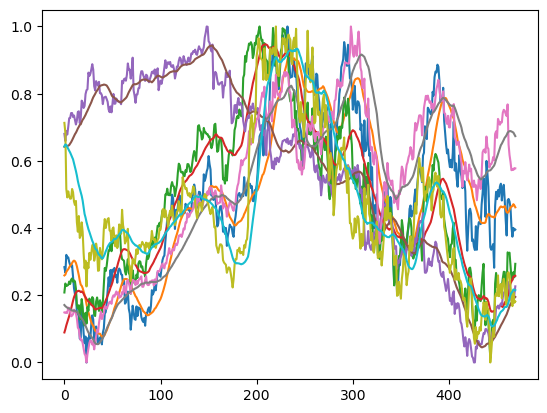

,AAPL_Value,AAPL_MA20,MSFT_Value,MSFT_MA20,CMCSA_Value,CMCSA_MA20,COST_Value,COST_MA20,QCOM_Value,QCOM_MA20,ADBE_Value,ADBE_MA20,SBUX_Value,SBUX_MA20,INTU_Value,INTU_MA20,AMD_Value,AMD_MA20,INTC_Value,INTC_MA20
count,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000
mean,0.495866,0.492794,0.482162,0.479014,0.579167,0.587889,0.533469,0.523779,0.452560,0.461506,0.502451,0.509006,0.531783,0.531778,0.350727,0.349249,0.388007,0.391417,0.519023,0.531789
std,0.235752,0.225720,0.236322,0.231829,0.267490,0.259055,0.235399,0.234726,0.218677,0.205217,0.267808,0.257953,0.263578,0.258639,0.244272,0.238807,0.218130,0.208087,0.252227,0.243380
min,0.000000,0.076756,0.015284,0.089409,0.000000,0.045101,0.000000,0.054367,0.000000,0.107125,0.000000,0.028077,0.000000,0.070103,0.000000,0.055437,0.000000,0.026649,0.000000,0.030993
25%,0.325704,0.338701,0.281618,0.277038,0.346764,0.379192,0.353530,0.312941,0.312793,0.337115,0.305909,0.315194,0.298077,0.304454,0.147254,0.135926,0.228956,0.235358,0.315248,0.355660
50%,0.487053,0.466664,0.469089,0.455275,0.643483,0.645003,0.575869,0.565663,0.406967,0.410483,0.481364,0.493710,0.601674,0.594596,0.287549,0.302450,0.340143,0.344116,0.574850,0.584284
75%,0.671935,0.697500,0.657286,0.651653,0.812443,0.814927,0.722474,0.709949,0.529889,0.534227,0.729433,0.768225,0.768162,0.761514,0.532005,0.549970,0.506889,0.508522,0.698577,0.714258
max,1.000000,0.914486,1.000000,0.947165,1.000000,0.943453,1.000000,0.916482,1.000000,0.933817,1.000000,0.947739,1.000000,0.901229,1.000000,0.907443,1.000000,0.893154,1.000000,0.921333


In [4]:
for icol in range(int(len(AllDataFrame.columns)/2)):
  
   plt.plot(AllDataFrame[AllDataFrame.columns[icol]])
plt.show()

AllDataFrame.describe()

In [5]:
def Split_Train_Test(AllDataFrame,TestDays,day):
  TotalDataLengh=len(AllDataFrame)
  trainIndex_x=np.zeros(TotalDataLengh,dtype=bool)
  trainIndex_y=np.zeros(TotalDataLengh,dtype=bool)
  testIndex_x=np.zeros(TotalDataLengh,dtype=bool)
  testIndex_y=np.zeros(TotalDataLengh,dtype=bool)

  trainIndex_x[day:TotalDataLengh-(TestDays-day)-1]=True
  trainIndex_y[TotalDataLengh-(TestDays-day)-1]=True
  testIndex_x[day+1:TotalDataLengh-(TestDays-day)]=True
  testIndex_y[TotalDataLengh-(TestDays-day)]=True

  train_x=AllDataFrame[trainIndex_x]
  test_x=AllDataFrame[testIndex_x]

  train_y=AllDataFrame[trainIndex_y]
  test_y=AllDataFrame[testIndex_y]

  return train_x,train_y,test_x,test_y

def toTensor(x):

  x = torch.tensor(np.array(x), dtype=torch.float)
  return x
def outputColumn(AllDataFrame):
  NewDataFrame=pd.DataFrame()
  for symbol in stock_files:
    
    columnValue=symbol+"_Value"
    
    NewDataFrame[columnValue]=AllDataFrame[columnValue]
  return NewDataFrame


In [6]:
def makeBatch(dataframe,batchwindow):
  if torch.is_tensor(dataframe):

    data_raw = dataframe.detach().numpy() # convert to numpy array
  else:
    data_raw = dataframe.to_numpy()
  data = []
    
    # create all possible sequences of length seq_len
  for index in range(len(data_raw) - batchwindow): 
      data.append(data_raw[index: index + batchwindow])
      
  return torch.tensor(data,dtype=torch.float)



In [7]:
#Functions to create a Graph based on pearson correalation and asociation analysis
AssociationPara=[0.1,0.1,1.7,0.01]
Corr=0.70

def generateEdge(train_x):
  
  NoMADataFrame=pd.DataFrame()
  for symbol in stock_files:
    NoMADataFrame[symbol+"_Value"]=train_x[symbol+"_Value"]
  StartEdge=[]
  EndEdge=[]
  StartEdge,EndEdge=PersonCorrelation(NoMADataFrame,StartEdge,EndEdge)
  StartEdge,EndEdge=AssociationAnalysis(NoMADataFrame,StartEdge,EndEdge,True)

  
  edge_index = torch.tensor([StartEdge,
                          EndEdge], dtype=torch.long)
  return edge_index

def PersonCorrelation(NoMADataFrame,StartEdge,EndEdge):
  CorrDataFrame=NoMADataFrame.corr(method ='pearson')
 

  StartEdgeCorr=np.where(np.array(CorrDataFrame)>Corr )[0]
  EndEdgeCorr=np.where(np.array(CorrDataFrame)>Corr)[1]
  
  for i in range(len(StartEdgeCorr)):
    if StartEdgeCorr[i]!=EndEdgeCorr[i]:
      StartEdge.append(StartEdgeCorr[i])
      EndEdge.append(EndEdgeCorr[i])
  return StartEdge,EndEdge

def AssociationAnalysis(AllDailyReturnFrame_AssociationAnalysis,StartEdgeCorr,EndEdgeCorr,GoAssociationAnalysis):
  from mlxtend.frequent_patterns import apriori, association_rules
  if GoAssociationAnalysis==False:
    return [],[]
  
  AllData=[]
  for date in AllDailyReturnFrame_AssociationAnalysis.index:
    DateData=AllDailyReturnFrame_AssociationAnalysis.loc[date]
    UpData=[]
    NoChangeData=[]
    DownData=[]
    for eachSymbol in DateData.index:
      if DateData[eachSymbol]>AssociationPara[3]:
        
        UpData.append(eachSymbol.split('_')[0])
        
      elif DateData[eachSymbol]<AssociationPara[3]:
        DownData.append(eachSymbol.split('_')[0])
      else:
        NoChangeData.append(eachSymbol.split('_')[0])
    
    
    AllData.append(UpData)
    AllData.append(DownData)

  # Convert transactions into a DataFrame of one-hot encoded transactions
  transactions = pd.DataFrame(AllData)
  transactions = transactions.apply(lambda x: pd.Series(1, index=x.dropna()), axis=1).fillna(0)

  # create frequent itemsets
  frequent_itemsets = apriori(transactions, min_support=AssociationPara[0], use_colnames=True)

  # create association rules
  rules = association_rules(frequent_itemsets, metric="lift", min_threshold=AssociationPara[2])

  # Filter rules based on confidence
  rules = rules[rules['confidence'] >= AssociationPara[1]]
 
  for _, row in rules.iterrows():
    item1, item2 = list(row['antecedents'])[0], list(row['consequents'])[0]
    item1Index = np.where(np.array(stock_files) == item1 + ".csv")[0]
    item2Index = np.where(np.array(stock_files) == item2 + ".csv")[0]
    if len(item1Index) > 0 and len(item2Index) > 0:
      StartEdgeCorr.append(item1Index[0])
      EndEdgeCorr.append(item2Index[0])
      StartEdgeCorr.append(item2Index[0])
      EndEdgeCorr.append(item1Index[0])

  print(len(EndEdgeCorr))
  return StartEdgeCorr, EndEdgeCorr

In [8]:
#Function to draw the graph
def graphDrawing(edge_index, dataframe, symbols):
    import matplotlib.pyplot as plt
    import networkx as nx
    from sklearn.preprocessing import MinMaxScaler
    
    dataframe = outputColumn(dataframe)
    labels = dataframe.diff() / dataframe
    labels = labels.tail(1)
    labels[labels < 0.01] = 1
    labels[labels > -0.01] = 1
    labels[labels >= 0.01] = 2
    labels[labels <= -0.01] = 0

    edges_raw = edge_index.numpy()
    edges = [(x, y) for x, y in zip(edges_raw[0, :], edges_raw[1, :])]
    labelsDict = {}
    pos = {}

    G = nx.Graph()
    G.add_nodes_from(list(range(len(symbols))))
    G.add_edges_from(edges)
    
    fig, ax = plt.subplots() 
    options = {
        'node_size': 50,
        'width': 0.6,
    }
    with_labels = True
    if len(symbols) > 30:
        with_labels = False
    
    values = np.array(labels)
    for i in range(len(symbols)):
        labelsDict[i] = symbols[i]
    
    colorLeft = np.array([112, 224, 112])
    colorRight = np.array([224, 112, 112])
    scaled = MinMaxScaler().fit_transform(values.reshape(-1, 1))
    colors = np.array([a * colorRight + (1 - a) * colorLeft for a in scaled], dtype=np.int64)

    MyPos = {}
    for node in G.nodes:
        MyPos[node] = (np.sin(node * 360 / len(symbols)), np.cos(node * 360 / len(symbols)))

    nx.draw(G, MyPos, with_labels=with_labels, labels=labelsDict, node_color=colors / 255, cmap=plt.cm.tab10, font_weight='bold', ax=ax, **options)

    plt.show()

In [9]:
#hyper parameter
NumberOfFeatures=len(AllDataFrame.columns)
NumberOfOutput=len(stock_files)
input_dim = NumberOfFeatures
hidden_dim = 32
num_layers = 2
output_dim = NumberOfOutput
num_epochs = 30

In [10]:
class MyGNN(MessagePassing):
    def __init__(self, in_channels, out_channels,havabias):
        super(MyGNN, self).__init__(aggr='add') 
        self.weight1=torch.nn.Parameter(torch.Tensor(in_channels, 16))
        self.weight2 = torch.nn.Parameter(torch.Tensor(16, out_channels))
        self.bias1 = torch.nn.Parameter(torch.Tensor(16))
        self.bias2= torch.nn.Parameter(torch.Tensor(out_channels))
          
         #flag that determines whether to include bias in the final layer
        if havabias:
            self.bias = torch.nn.Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)
        if self.weight1 is not None:
          stdv = math.sqrt(3.0 / (self.weight1.size(-2) + self.weight1.size(-1)))
          self.weight1.data.normal_(-stdv, stdv)
        if self.weight2 is not None:
          stdv = math.sqrt(3.0 / (self.weight2.size(-2) + self.weight2.size(-1)))
          self.weight2.data.normal_(-stdv, stdv)
        
        #The biases are initialized to zero
        if self.bias1 is not None:
          self.bias1.data.fill_(0)
        if self.bias2 is not None:
          self.bias2.data.fill_(0)
        if self.bias is not None:
          self.bias.data.fill_(0)
          
    def forward(self, x, edge_index):
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        
        x = torch.matmul(x, self.weight1)+self.bias1  ##fully connected layer1
        x=F.relu(x) # activation function
        x = torch.matmul(x, self.weight2)+self.bias2  ##fully connected layer2
       
        #degree calculation (number of edges connected)
        row, col = edge_index
        deg = degree(row, x.size(0), dtype=x.dtype)
        #inverse square root of the degree (to ensure that the nodes with higher degree do not 
        #disproportionately influence the output)
        deg_inv_sqrt = deg.pow(-0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        #this is where the message from the neighbor nodes is passed
        return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x,
                              norm=norm)
    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j


class LSTM(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        
        
        return out
 
class Network_RNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(Network_RNN, self).__init__()
        self.lstm = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
        self.linear=nn.Linear(output_dim,output_dim)
        
    def forward(self, x):
        
        out = self.lstm(x)
        out=F.relu(out)
        out=self.linear(out)
        out=F.relu(out)
        out=self.linear(out)
        return out[-1,:]

class Network_RNNplusGNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim,edge_index):
        super(Network_RNNplusGNN, self).__init__()
        self.edge_index=edge_index

        self.lstm1 = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=input_dim, num_layers=num_layers)
        self.linear1=nn.Linear(input_dim,256)
        self.linear2=nn.Linear(256, output_dim)
        
        self.conv1 = MyGNN(output_dim, 256,havabias=False)
        self.leakyrelu=torch.nn.LeakyReLU(0.01)
        self.conv2 = MyGNN(256,output_dim,havabias=True)
        self.lstm2 = LSTM(input_dim=output_dim, hidden_dim=hidden_dim, output_dim=input_dim, num_layers=num_layers)
        self.linear3=nn.Linear(input_dim,output_dim)

    def forward(self, x):
        
        x = self.lstm1(x)
        #print("After LSTM1,",x.size())
        x=self.linear1(x)
        #print("After linear1,",x.size())
        x=self.linear2(x)
        #print("After linear2,",x.size())
        x = self.conv1(x, self.edge_index)
        #print("After conv1",x.size())
        x= self.leakyrelu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, self.edge_index)

        #print("After conv2",x.size())
        x=makeBatch(x,11)
        x = self.lstm2(x)
        x=self.linear3(x)
        return x[-1,:]





===== Evaluating Parameters: Learning Rate = 0.001, Epochs = 10, Batch Size = 11 =====



===== TEST DAY 1 =====
--- Data Preparation ---
24
Generated Edge Index for Day 1
Training Data Shape: torch.Size([448, 11, 20])
Test Data Shape: torch.Size([448, 11, 20])
--- Model Initialization ---
--- Training Begins ---
Day 1 | Epoch 0/10 | Training Loss (MSE): 0.149587
Day 1 | Epoch 5/10 | Training Loss (MSE): 0.122765
Training Completed for Test Day 1 in 2.62 seconds.
Day 1 | Final Test Loss (MSE): 0.087011

Real Values in Tabular Form:
Stock  Real Ground Truth  Real Predicted Values
 AAPL         141.169998             113.830620
 MSFT         240.330002             226.173370
CMCSA          35.480000              31.652241
 COST         528.960022             339.125031
 QCOM         118.380005             117.163055
 ADBE         326.779999             323.611328
 SBUX          98.660004              70.124390
 INTU         379.709991             387.441040
  AMD          73.389999    

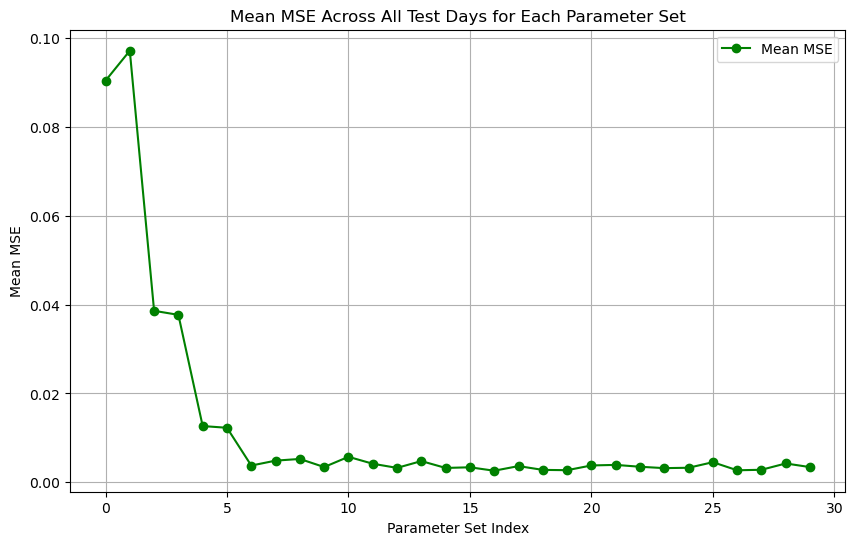

In [44]:
import torch
import torch.nn as nn
import numpy as np
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import json
import warnings

warnings.filterwarnings("ignore")

# ranges for the hyperparameters 
learning_rates = [0.001, 0.005, 0.01]
num_epochs_values = [10, 20, 30, 40, 50]
batch_sizes = [11, 21]

# early stopping criteria
patience = 5 
min_delta = 0.001

best_mse = float('inf')
best_params = {}
all_mse_results = []  

# Perform grid search by looping over all combinations of the hyperparameters
for lr, num_epochs, batch_size in itertools.product(
        learning_rates, num_epochs_values, batch_sizes):

    print(f"\n\n===== Evaluating Parameters: Learning Rate = {lr}, Epochs = {num_epochs}, Batch Size = {batch_size} =====\n")

    PredictionAlltime = []
    GroundTruthAlltime = []
    testMse = []

    for day in range(TestDays):
        print(f"\n\n===== TEST DAY {day + 1} =====")
        
        # Data Preparation
        print(f"--- Data Preparation ---")
        train_x, train_y, test_x, test_y = Split_Train_Test(AllDataFrame, TestDays, day)

        # Initialize edge index for each test day based on the training data
        edge_index = generateEdge(train_x)
        print(f"Generated Edge Index for Day {day + 1}")

        train_x = makeBatch(train_x, batch_size)
        train_y = toTensor(outputColumn(train_y))
        test_x = makeBatch(test_x, batch_size)
        test_y = toTensor(outputColumn(test_y))
        
        print(f"Training Data Shape: {train_x.shape}")
        print(f"Test Data Shape: {test_x.shape}")

        # Model Initialization
        print(f"--- Model Initialization ---")
        model = Network_RNNplusGNN(
            input_dim=input_dim,
            hidden_dim=hidden_dim,  
            output_dim=output_dim,
            num_layers=num_layers, 
            edge_index=edge_index 
        )

        criterion = torch.nn.MSELoss(reduction='mean')
        optimiser = torch.optim.Adam(model.parameters(), lr=lr)

        start_time = time.time()
        print(f"--- Training Begins ---")

        best_test_loss = float('inf')
        early_stopping_counter = 0

        for t in range(num_epochs):
            model.train()
            y_trainPrediction = model(train_x)

            loss = criterion(y_trainPrediction, train_y)
            if t % 5 == 0:
                print(f"Day {day + 1} | Epoch {t}/{num_epochs} | Training Loss (MSE): {loss.item():.6f}")

            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

            # Testing
            model.eval() 
            with torch.no_grad():
                y_testPrediction = model(test_x)
                test_loss = criterion(y_testPrediction, test_y)

            if test_loss.item() < best_test_loss - min_delta:
                best_test_loss = test_loss.item()
                early_stopping_counter = 0
            else:
                early_stopping_counter += 1

            if early_stopping_counter >= patience:
                print(f"Early stopping triggered after {t + 1} epochs on Test Day {day + 1}.")
                break  # Exit the epoch loop

        print(f"Training Completed for Test Day {day + 1} in {time.time() - start_time:.2f} seconds.")
        print(f"Day {day + 1} | Final Test Loss (MSE): {best_test_loss:.6f}")

        # Store the best loss for this test day
        testMse.append(best_test_loss)

        # Initialize lists to store real values and stock names
        real_test_y_all = []
        real_predictions_all = []
        stock_names = []

        test_y_np = test_y.detach().numpy()  # Convert tensor to numpy array
        test_y_np = test_y_np[0]
        y_testPrediction_np = y_testPrediction.detach().numpy()  # Convert tensor to numpy array

        for i, symbol in enumerate(stock_files):
            stock_names.append(symbol)
            scaler = ScalerList[i]

            if test_y_np.ndim == 2 and y_testPrediction_np.ndim == 2:
                real_test_y = scaler.inverse_transform(test_y_np[:, i].reshape(-1, 1)).flatten()
                real_predictions = scaler.inverse_transform(y_testPrediction_np[:, i].reshape(-1, 1)).flatten()
            else:
                real_test_y = scaler.inverse_transform(np.array([test_y_np[i]]).reshape(-1, 1)).flatten()
                real_predictions = scaler.inverse_transform(np.array([y_testPrediction_np[i]]).reshape(-1, 1)).flatten()
            real_test_y_all.append(real_test_y)
            real_predictions_all.append(real_predictions)

        # Create DataFrame for tabular output
        result_df = pd.DataFrame({
            'Stock': stock_names,
            'Real Ground Truth': np.concatenate(real_test_y_all),
            'Real Predicted Values': np.concatenate(real_predictions_all)
        })
        print("\nReal Values in Tabular Form:")
        print(result_df.to_string(index=False))
        print(f"========================== End of Test Day {day + 1} ==========================\n")

    mean_mse = np.mean(testMse)
    all_mse_results.append(mean_mse)
    print(f"\nMean MSE Across All Test Days for Current Parameters: {mean_mse:.6f}")

    if mean_mse < best_mse:
        best_mse = mean_mse
        best_params = {
            'Learning Rate': lr,
            'Epochs': num_epochs,
            'Batch Size': batch_size
        }

print("\n\n===== Grid Search Complete =====")
print("Best Parameters:", best_params)
print("Best Mean Test MSE Across All Days:", best_mse)

plt.figure(figsize=(10, 6))
plt.title("Mean MSE Across All Test Days for Each Parameter Set")
plt.plot(all_mse_results, marker='o', color='g', label="Mean MSE")
plt.xlabel("Parameter Set Index")
plt.ylabel("Mean MSE")
plt.legend()
plt.grid(True)
plt.show()

with open('best_params.json', 'w') as f:
    json.dump(best_params, f)


In [47]:
import pandas as pd

learning_rates = [0.001, 0.005, 0.01]
num_epochs_values = [10, 20, 30, 40, 50]
batch_sizes = [11, 21]

all_params = list(itertools.product(learning_rates, num_epochs_values, batch_sizes))

results_df = pd.DataFrame(all_params, columns=['Learning Rate', 'Epochs', 'Batch Size'])
results_df['Mean MSE'] = all_mse_results

print("\nHyperparameter Tuning Results:")
print(results_df.to_string(index=False))


Hyperparameter Tuning Results:
 Learning Rate  Epochs  Batch Size  Mean MSE
         0.001      10          11  0.090401
         0.001      10          21  0.097147
         0.001      20          11  0.038606
         0.001      20          21  0.037696
         0.001      30          11  0.012665
         0.001      30          21  0.012280
         0.001      40          11  0.003775
         0.001      40          21  0.004882
         0.001      50          11  0.005263
         0.001      50          21  0.003439
         0.005      10          11  0.005743
         0.005      10          21  0.004185
         0.005      20          11  0.003252
         0.005      20          21  0.004782
         0.005      30          11  0.003238
         0.005      30          21  0.003383
         0.005      40          11  0.002612
         0.005      40          21  0.003653
         0.005      50          11  0.002800
         0.005      50          21  0.002732
         0.010      10 

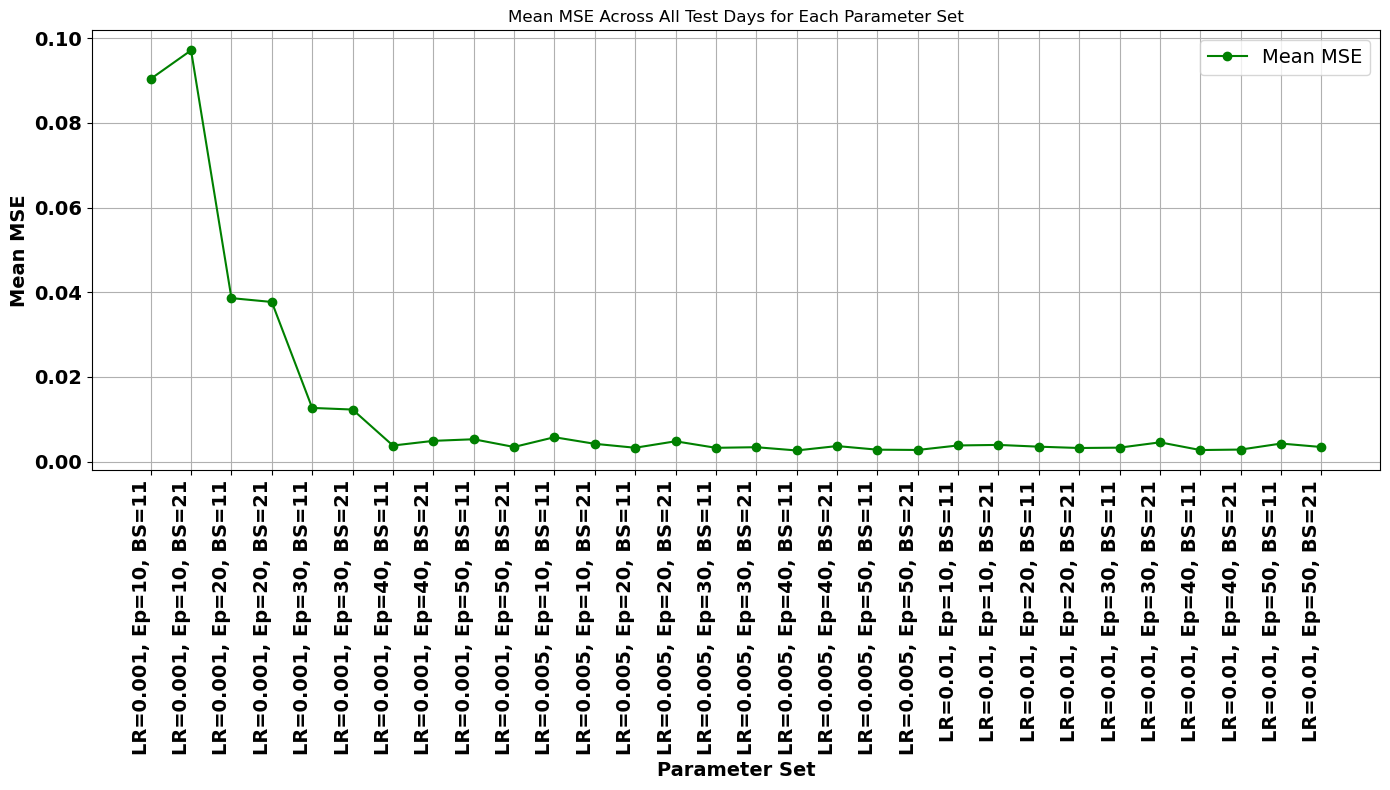

In [57]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare labels for each parameter set
param_labels = [
    f"LR={lr}, Ep={epochs}, BS={batch_size}"
    for lr, epochs, batch_size in itertools.product(learning_rates, num_epochs_values, batch_sizes)
]

# Plot the mean MSE for each parameter set
plt.figure(figsize=(14, 8))
plt.title("Mean MSE Across All Test Days for Each Parameter Set")
plt.plot(param_labels, all_mse_results, marker='o', linestyle='-', color='g', label="Mean MSE")

# Labeling and formatting
plt.xlabel("Parameter Set", fontweight='bold',fontsize=14)
plt.ylabel("Mean MSE", fontweight='bold',fontsize=14)
plt.xticks(rotation=90, ha='right', fontweight='bold',fontsize=14)  
plt.yticks(fontweight='bold',fontsize=14) 
plt.legend(fontsize=14)
plt.grid(True)

plt.tight_layout()

plt.savefig('high_quality_plot.png', dpi=1500, bbox_inches='tight')

plt.show()




===== Running Model with Best Parameters: Learning Rate = 0.005, Epochs = 40, Batch Size = 11 =====



===== TEST DAY 1 =====
--- Data Preparation ---


c:\ProgramData\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


26
Generated Edge Index for Day 1


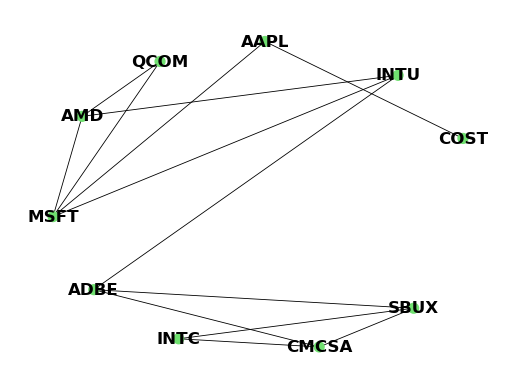

Training Data Shape: torch.Size([408, 11, 20])
Test Data Shape: torch.Size([408, 11, 20])
--- Model Initialization ---
--- Training Begins ---
Day 1 | Epoch 0/40 | Training Loss (MSE): 0.098412
Day 1 | Epoch 5/40 | Training Loss (MSE): 0.011696
Day 1 | Epoch 10/40 | Training Loss (MSE): 0.001619
Day 1 | Epoch 15/40 | Training Loss (MSE): 0.003202
Day 1 | Epoch 20/40 | Training Loss (MSE): 0.001417
Day 1 | Epoch 25/40 | Training Loss (MSE): 0.000419
Day 1 | Epoch 30/40 | Training Loss (MSE): 0.000360
Day 1 | Epoch 35/40 | Training Loss (MSE): 0.000321
Training Completed for Test Day 1 in 5.49 seconds.
Day 1 | Final Test Loss (MSE): 0.001598
MSE for each stock on Test Day 1:
AAPL: 0.004522
MSFT: 0.001898
CMCSA: 0.001858
COST: 0.000003
QCOM: 0.001562
ADBE: 0.000553
SBUX: 0.001023
INTU: 0.000938
AMD: 0.001199
INTC: 0.002425

Real Values in Tabular Form:
Stock  Real Ground Truth (Original)  Real Predicted Values (Original)  Test Day
 AAPL                    142.449982                       

c:\ProgramData\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


26
Generated Edge Index for Day 2


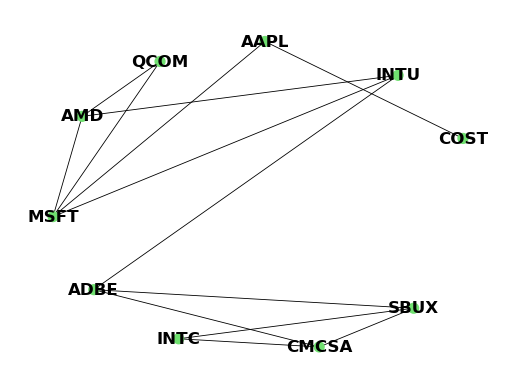

Training Data Shape: torch.Size([408, 11, 20])
Test Data Shape: torch.Size([408, 11, 20])
--- Model Initialization ---
--- Training Begins ---
Day 2 | Epoch 0/40 | Training Loss (MSE): 0.093881
Day 2 | Epoch 5/40 | Training Loss (MSE): 0.022088
Day 2 | Epoch 10/40 | Training Loss (MSE): 0.003101
Day 2 | Epoch 15/40 | Training Loss (MSE): 0.002610
Day 2 | Epoch 20/40 | Training Loss (MSE): 0.000864
Day 2 | Epoch 25/40 | Training Loss (MSE): 0.000490
Day 2 | Epoch 30/40 | Training Loss (MSE): 0.000324
Day 2 | Epoch 35/40 | Training Loss (MSE): 0.000201
Training Completed for Test Day 2 in 5.16 seconds.
Day 2 | Final Test Loss (MSE): 0.001627
MSE for each stock on Test Day 2:
AAPL: 0.001888
MSFT: 0.002242
CMCSA: 0.000002
COST: 0.001713
QCOM: 0.003654
ADBE: 0.000435
SBUX: 0.002303
INTU: 0.002665
AMD: 0.000371
INTC: 0.001000

Real Values in Tabular Form:
Stock  Real Ground Truth (Original)  Real Predicted Values (Original)  Test Day
 AAPL                    146.100006                       

c:\ProgramData\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


26
Generated Edge Index for Day 3


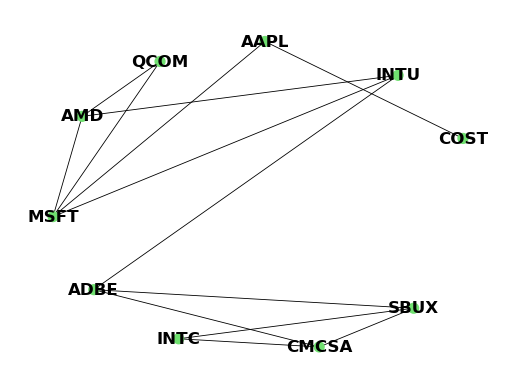

Training Data Shape: torch.Size([408, 11, 20])
Test Data Shape: torch.Size([408, 11, 20])
--- Model Initialization ---
--- Training Begins ---
Day 3 | Epoch 0/40 | Training Loss (MSE): 0.086566
Day 3 | Epoch 5/40 | Training Loss (MSE): 0.022340
Day 3 | Epoch 10/40 | Training Loss (MSE): 0.003528
Day 3 | Epoch 15/40 | Training Loss (MSE): 0.001732
Day 3 | Epoch 20/40 | Training Loss (MSE): 0.000546
Day 3 | Epoch 25/40 | Training Loss (MSE): 0.000678
Day 3 | Epoch 30/40 | Training Loss (MSE): 0.000251
Day 3 | Epoch 35/40 | Training Loss (MSE): 0.000072
Training Completed for Test Day 3 in 5.70 seconds.
Day 3 | Final Test Loss (MSE): 0.000198
MSE for each stock on Test Day 3:
AAPL: 0.000644
MSFT: 0.000002
CMCSA: 0.000471
COST: 0.000489
QCOM: 0.000207
ADBE: 0.000070
SBUX: 0.000063
INTU: 0.000010
AMD: 0.000011
INTC: 0.000016

Real Values in Tabular Form:
Stock  Real Ground Truth (Original)  Real Predicted Values (Original)  Test Day
 AAPL                    146.399994                       

c:\ProgramData\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


26
Generated Edge Index for Day 4


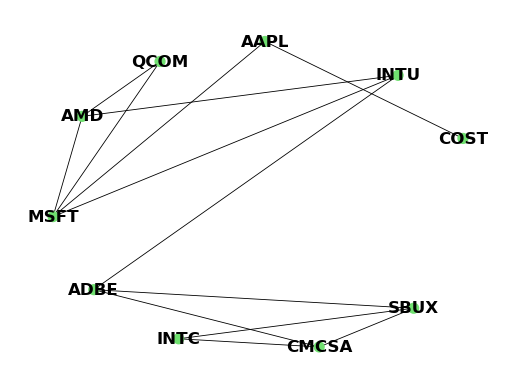

Training Data Shape: torch.Size([408, 11, 20])
Test Data Shape: torch.Size([408, 11, 20])
--- Model Initialization ---
--- Training Begins ---
Day 4 | Epoch 0/40 | Training Loss (MSE): 0.106745
Day 4 | Epoch 5/40 | Training Loss (MSE): 0.034949
Day 4 | Epoch 10/40 | Training Loss (MSE): 0.002021
Day 4 | Epoch 15/40 | Training Loss (MSE): 0.005369
Day 4 | Epoch 20/40 | Training Loss (MSE): 0.001786
Day 4 | Epoch 25/40 | Training Loss (MSE): 0.000283
Day 4 | Epoch 30/40 | Training Loss (MSE): 0.000791
Day 4 | Epoch 35/40 | Training Loss (MSE): 0.000443
Training Completed for Test Day 4 in 4.79 seconds.
Day 4 | Final Test Loss (MSE): 0.000189
MSE for each stock on Test Day 4:
AAPL: 0.000313
MSFT: 0.000186
CMCSA: 0.000332
COST: 0.000002
QCOM: 0.000062
ADBE: 0.000192
SBUX: 0.000674
INTU: 0.000013
AMD: 0.000056
INTC: 0.000064

Real Values in Tabular Form:
Stock  Real Ground Truth (Original)  Real Predicted Values (Original)  Test Day
 AAPL                    145.429993                       

c:\ProgramData\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


26
Generated Edge Index for Day 5


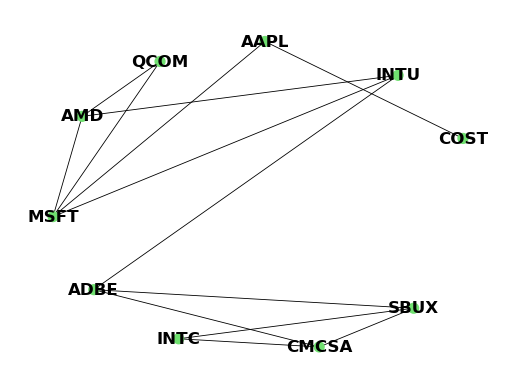

Training Data Shape: torch.Size([408, 11, 20])
Test Data Shape: torch.Size([408, 11, 20])
--- Model Initialization ---
--- Training Begins ---
Day 5 | Epoch 0/40 | Training Loss (MSE): 0.080038
Day 5 | Epoch 5/40 | Training Loss (MSE): 0.009369
Day 5 | Epoch 10/40 | Training Loss (MSE): 0.003326
Day 5 | Epoch 15/40 | Training Loss (MSE): 0.001622
Day 5 | Epoch 20/40 | Training Loss (MSE): 0.000791
Day 5 | Epoch 25/40 | Training Loss (MSE): 0.000558
Day 5 | Epoch 30/40 | Training Loss (MSE): 0.000270
Day 5 | Epoch 35/40 | Training Loss (MSE): 0.000188
Training Completed for Test Day 5 in 5.40 seconds.
Day 5 | Final Test Loss (MSE): 0.003449
MSE for each stock on Test Day 5:
AAPL: 0.006465
MSFT: 0.010737
CMCSA: 0.000640
COST: 0.001656
QCOM: 0.002291
ADBE: 0.000247
SBUX: 0.001504
INTU: 0.001237
AMD: 0.006945
INTC: 0.002768

Real Values in Tabular Form:
Stock  Real Ground Truth (Original)  Real Predicted Values (Original)  Test Day
 AAPL                    140.089996                       

c:\ProgramData\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


26
Generated Edge Index for Day 6


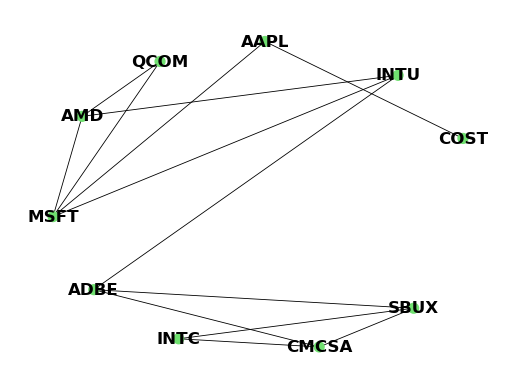

Training Data Shape: torch.Size([408, 11, 20])
Test Data Shape: torch.Size([408, 11, 20])
--- Model Initialization ---
--- Training Begins ---
Day 6 | Epoch 0/40 | Training Loss (MSE): 0.070051
Day 6 | Epoch 5/40 | Training Loss (MSE): 0.014795
Day 6 | Epoch 10/40 | Training Loss (MSE): 0.001430
Day 6 | Epoch 15/40 | Training Loss (MSE): 0.002218
Day 6 | Epoch 20/40 | Training Loss (MSE): 0.000486
Day 6 | Epoch 25/40 | Training Loss (MSE): 0.000282
Day 6 | Epoch 30/40 | Training Loss (MSE): 0.000288
Day 6 | Epoch 35/40 | Training Loss (MSE): 0.000148
Training Completed for Test Day 6 in 5.52 seconds.
Day 6 | Final Test Loss (MSE): 0.000795
MSE for each stock on Test Day 6:
AAPL: 0.000542
MSFT: 0.001492
CMCSA: 0.000251
COST: 0.000046
QCOM: 0.004879
ADBE: 0.000030
SBUX: 0.000004
INTU: 0.000260
AMD: 0.000132
INTC: 0.000317

Real Values in Tabular Form:
Stock  Real Ground Truth (Original)  Real Predicted Values (Original)  Test Day
 AAPL                    140.419998                       

c:\ProgramData\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


26
Generated Edge Index for Day 7


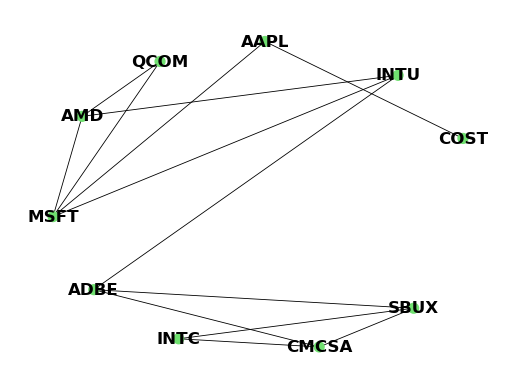

Training Data Shape: torch.Size([408, 11, 20])
Test Data Shape: torch.Size([408, 11, 20])
--- Model Initialization ---
--- Training Begins ---
Day 7 | Epoch 0/40 | Training Loss (MSE): 0.122446
Day 7 | Epoch 5/40 | Training Loss (MSE): 0.025812
Day 7 | Epoch 10/40 | Training Loss (MSE): 0.003859
Day 7 | Epoch 15/40 | Training Loss (MSE): 0.004129
Day 7 | Epoch 20/40 | Training Loss (MSE): 0.001794
Day 7 | Epoch 25/40 | Training Loss (MSE): 0.000603
Day 7 | Epoch 30/40 | Training Loss (MSE): 0.000734
Day 7 | Epoch 35/40 | Training Loss (MSE): 0.000334
Training Completed for Test Day 7 in 5.62 seconds.
Day 7 | Final Test Loss (MSE): 0.000972
MSE for each stock on Test Day 7:
AAPL: 0.000332
MSFT: 0.003322
CMCSA: 0.001166
COST: 0.000163
QCOM: 0.003962
ADBE: 0.000021
SBUX: 0.000383
INTU: 0.000205
AMD: 0.000144
INTC: 0.000022

Real Values in Tabular Form:
Stock  Real Ground Truth (Original)  Real Predicted Values (Original)  Test Day
 AAPL                    138.979996                       

c:\ProgramData\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


26
Generated Edge Index for Day 8


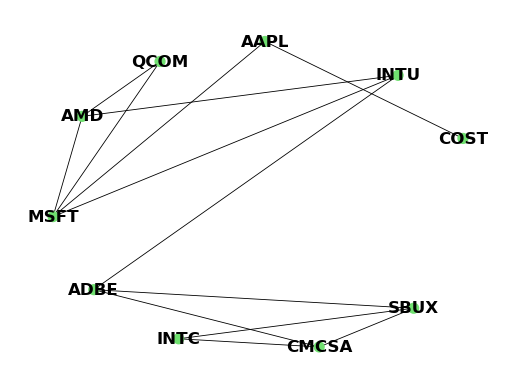

Training Data Shape: torch.Size([408, 11, 20])
Test Data Shape: torch.Size([408, 11, 20])
--- Model Initialization ---
--- Training Begins ---
Day 8 | Epoch 0/40 | Training Loss (MSE): 0.112207
Day 8 | Epoch 5/40 | Training Loss (MSE): 0.023558
Day 8 | Epoch 10/40 | Training Loss (MSE): 0.004948
Day 8 | Epoch 15/40 | Training Loss (MSE): 0.004064
Day 8 | Epoch 20/40 | Training Loss (MSE): 0.000706
Day 8 | Epoch 25/40 | Training Loss (MSE): 0.000684
Day 8 | Epoch 30/40 | Training Loss (MSE): 0.000726
Day 8 | Epoch 35/40 | Training Loss (MSE): 0.000243
Training Completed for Test Day 8 in 5.62 seconds.
Day 8 | Final Test Loss (MSE): 0.000127
MSE for each stock on Test Day 8:
AAPL: 0.000175
MSFT: 0.000018
CMCSA: 0.000246
COST: 0.000173
QCOM: 0.000245
ADBE: 0.000027
SBUX: 0.000279
INTU: 0.000000
AMD: 0.000031
INTC: 0.000077

Real Values in Tabular Form:
Stock  Real Ground Truth (Original)  Real Predicted Values (Original)  Test Day
 AAPL                    138.339996                       

c:\ProgramData\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


26
Generated Edge Index for Day 9


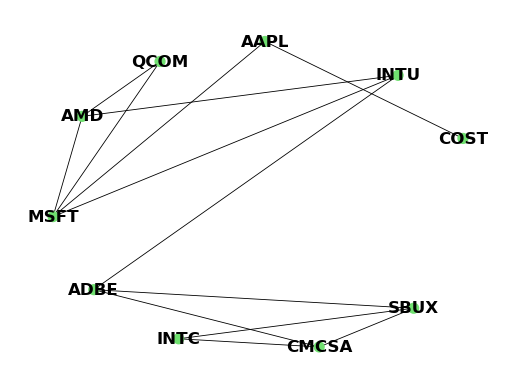

Training Data Shape: torch.Size([408, 11, 20])
Test Data Shape: torch.Size([408, 11, 20])
--- Model Initialization ---
--- Training Begins ---
Day 9 | Epoch 0/40 | Training Loss (MSE): 0.066191
Day 9 | Epoch 5/40 | Training Loss (MSE): 0.009120
Day 9 | Epoch 10/40 | Training Loss (MSE): 0.002591
Day 9 | Epoch 15/40 | Training Loss (MSE): 0.001610
Day 9 | Epoch 20/40 | Training Loss (MSE): 0.000803
Day 9 | Epoch 25/40 | Training Loss (MSE): 0.000186
Day 9 | Epoch 30/40 | Training Loss (MSE): 0.000391
Day 9 | Epoch 35/40 | Training Loss (MSE): 0.000121
Training Completed for Test Day 9 in 5.66 seconds.
Day 9 | Final Test Loss (MSE): 0.001661
MSE for each stock on Test Day 9:
AAPL: 0.003707
MSFT: 0.004678
CMCSA: 0.001688
COST: 0.000094
QCOM: 0.002819
ADBE: 0.000219
SBUX: 0.002681
INTU: 0.000396
AMD: 0.000205
INTC: 0.000119

Real Values in Tabular Form:
Stock  Real Ground Truth (Original)  Real Predicted Values (Original)  Test Day
 AAPL                    142.990005                       

c:\ProgramData\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


26
Generated Edge Index for Day 10


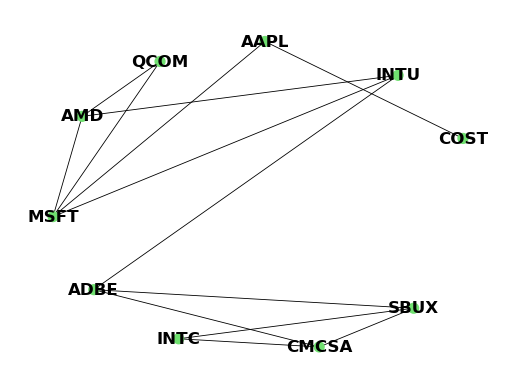

Training Data Shape: torch.Size([408, 11, 20])
Test Data Shape: torch.Size([408, 11, 20])
--- Model Initialization ---
--- Training Begins ---
Day 10 | Epoch 0/40 | Training Loss (MSE): 0.058519
Day 10 | Epoch 5/40 | Training Loss (MSE): 0.006897
Day 10 | Epoch 10/40 | Training Loss (MSE): 0.002334
Day 10 | Epoch 15/40 | Training Loss (MSE): 0.001062
Day 10 | Epoch 20/40 | Training Loss (MSE): 0.000220
Day 10 | Epoch 25/40 | Training Loss (MSE): 0.000366
Day 10 | Epoch 30/40 | Training Loss (MSE): 0.000179
Day 10 | Epoch 35/40 | Training Loss (MSE): 0.000036
Training Completed for Test Day 10 in 5.76 seconds.
Day 10 | Final Test Loss (MSE): 0.001592
MSE for each stock on Test Day 10:
AAPL: 0.003930
MSFT: 0.002037
CMCSA: 0.000076
COST: 0.001359
QCOM: 0.001904
ADBE: 0.000245
SBUX: 0.003563
INTU: 0.001748
AMD: 0.001046
INTC: 0.000012

Real Values in Tabular Form:
Stock  Real Ground Truth (Original)  Real Predicted Values (Original)  Test Day
 AAPL                    138.380005            

c:\ProgramData\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


26
Generated Edge Index for Day 11


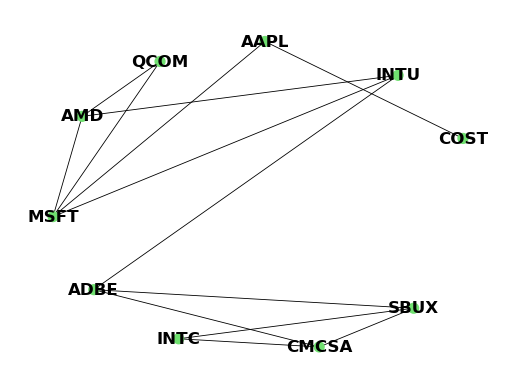

Training Data Shape: torch.Size([408, 11, 20])
Test Data Shape: torch.Size([408, 11, 20])
--- Model Initialization ---
--- Training Begins ---
Day 11 | Epoch 0/40 | Training Loss (MSE): 0.093317
Day 11 | Epoch 5/40 | Training Loss (MSE): 0.013847
Day 11 | Epoch 10/40 | Training Loss (MSE): 0.004934
Day 11 | Epoch 15/40 | Training Loss (MSE): 0.001609
Day 11 | Epoch 20/40 | Training Loss (MSE): 0.000732
Day 11 | Epoch 25/40 | Training Loss (MSE): 0.000691
Day 11 | Epoch 30/40 | Training Loss (MSE): 0.000227
Day 11 | Epoch 35/40 | Training Loss (MSE): 0.000141
Training Completed for Test Day 11 in 5.83 seconds.
Day 11 | Final Test Loss (MSE): 0.001909
MSE for each stock on Test Day 11:
AAPL: 0.004673
MSFT: 0.004314
CMCSA: 0.000467
COST: 0.000366
QCOM: 0.001310
ADBE: 0.000006
SBUX: 0.004257
INTU: 0.003180
AMD: 0.000249
INTC: 0.000264

Real Values in Tabular Form:
Stock  Real Ground Truth (Original)  Real Predicted Values (Original)  Test Day
 AAPL                    142.410004            

c:\ProgramData\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


26
Generated Edge Index for Day 12


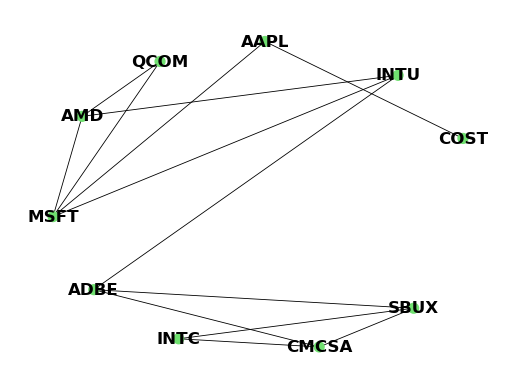

Training Data Shape: torch.Size([408, 11, 20])
Test Data Shape: torch.Size([408, 11, 20])
--- Model Initialization ---
--- Training Begins ---
Day 12 | Epoch 0/40 | Training Loss (MSE): 0.036817
Day 12 | Epoch 5/40 | Training Loss (MSE): 0.004623
Day 12 | Epoch 10/40 | Training Loss (MSE): 0.001432
Day 12 | Epoch 15/40 | Training Loss (MSE): 0.000748
Day 12 | Epoch 20/40 | Training Loss (MSE): 0.000507
Day 12 | Epoch 25/40 | Training Loss (MSE): 0.000204
Day 12 | Epoch 30/40 | Training Loss (MSE): 0.000182
Day 12 | Epoch 35/40 | Training Loss (MSE): 0.000083
Training Completed for Test Day 12 in 5.62 seconds.
Day 12 | Final Test Loss (MSE): 0.000113
MSE for each stock on Test Day 12:
AAPL: 0.000292
MSFT: 0.000051
CMCSA: 0.000126
COST: 0.000326
QCOM: 0.000003
ADBE: 0.000002
SBUX: 0.000073
INTU: 0.000025
AMD: 0.000000
INTC: 0.000237

Real Values in Tabular Form:
Stock  Real Ground Truth (Original)  Real Predicted Values (Original)  Test Day
 AAPL                    143.750000            

c:\ProgramData\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


26
Generated Edge Index for Day 13


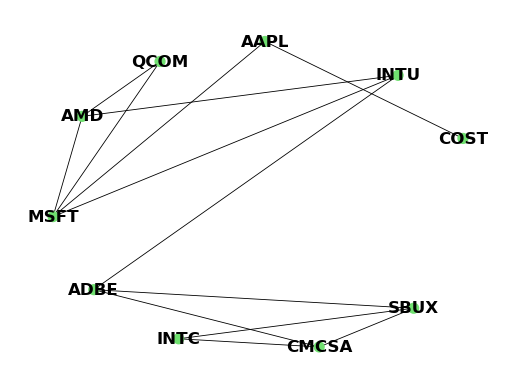

Training Data Shape: torch.Size([408, 11, 20])
Test Data Shape: torch.Size([408, 11, 20])
--- Model Initialization ---
--- Training Begins ---
Day 13 | Epoch 0/40 | Training Loss (MSE): 0.099976
Day 13 | Epoch 5/40 | Training Loss (MSE): 0.010034
Day 13 | Epoch 10/40 | Training Loss (MSE): 0.003375
Day 13 | Epoch 15/40 | Training Loss (MSE): 0.003395
Day 13 | Epoch 20/40 | Training Loss (MSE): 0.001024
Day 13 | Epoch 25/40 | Training Loss (MSE): 0.000977
Day 13 | Epoch 30/40 | Training Loss (MSE): 0.000355
Day 13 | Epoch 35/40 | Training Loss (MSE): 0.000329
Training Completed for Test Day 13 in 5.47 seconds.
Day 13 | Final Test Loss (MSE): 0.000295
MSE for each stock on Test Day 13:
AAPL: 0.000000
MSFT: 0.000008
CMCSA: 0.000414
COST: 0.000451
QCOM: 0.000515
ADBE: 0.000096
SBUX: 0.001359
INTU: 0.000093
AMD: 0.000016
INTC: 0.000002

Real Values in Tabular Form:
Stock  Real Ground Truth (Original)  Real Predicted Values (Original)  Test Day
 AAPL                    143.860001            

c:\ProgramData\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


26
Generated Edge Index for Day 14


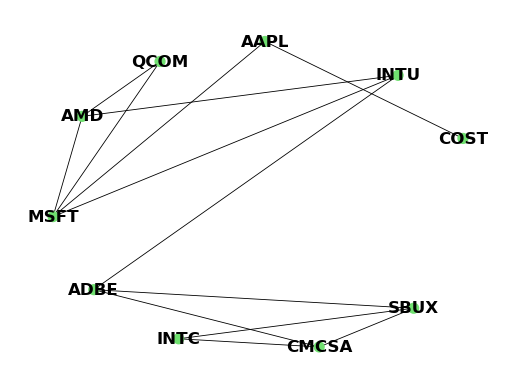

Training Data Shape: torch.Size([408, 11, 20])
Test Data Shape: torch.Size([408, 11, 20])
--- Model Initialization ---
--- Training Begins ---
Day 14 | Epoch 0/40 | Training Loss (MSE): 0.094237
Day 14 | Epoch 5/40 | Training Loss (MSE): 0.021510
Day 14 | Epoch 10/40 | Training Loss (MSE): 0.000869
Day 14 | Epoch 15/40 | Training Loss (MSE): 0.003834
Day 14 | Epoch 20/40 | Training Loss (MSE): 0.001009
Day 14 | Epoch 25/40 | Training Loss (MSE): 0.000272
Day 14 | Epoch 30/40 | Training Loss (MSE): 0.000493
Day 14 | Epoch 35/40 | Training Loss (MSE): 0.000217
Training Completed for Test Day 14 in 5.80 seconds.
Day 14 | Final Test Loss (MSE): 0.000126
MSE for each stock on Test Day 14:
AAPL: 0.000047
MSFT: 0.000001
CMCSA: 0.000000
COST: 0.000541
QCOM: 0.000064
ADBE: 0.000005
SBUX: 0.000380
INTU: 0.000002
AMD: 0.000217
INTC: 0.000000

Real Values in Tabular Form:
Stock  Real Ground Truth (Original)  Real Predicted Values (Original)  Test Day
 AAPL                    143.389999            

c:\ProgramData\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


26
Generated Edge Index for Day 15


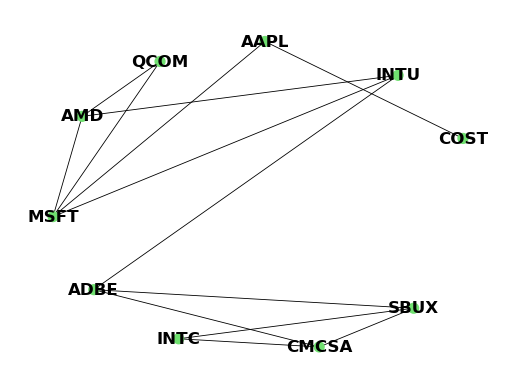

Training Data Shape: torch.Size([408, 11, 20])
Test Data Shape: torch.Size([408, 11, 20])
--- Model Initialization ---
--- Training Begins ---
Day 15 | Epoch 0/40 | Training Loss (MSE): 0.066474
Day 15 | Epoch 5/40 | Training Loss (MSE): 0.008945
Day 15 | Epoch 10/40 | Training Loss (MSE): 0.001481
Day 15 | Epoch 15/40 | Training Loss (MSE): 0.001798
Day 15 | Epoch 20/40 | Training Loss (MSE): 0.000797
Day 15 | Epoch 25/40 | Training Loss (MSE): 0.000165
Day 15 | Epoch 30/40 | Training Loss (MSE): 0.000396
Day 15 | Epoch 35/40 | Training Loss (MSE): 0.000090
Training Completed for Test Day 15 in 5.73 seconds.
Day 15 | Final Test Loss (MSE): 0.001297
MSE for each stock on Test Day 15:
AAPL: 0.002080
MSFT: 0.002769
CMCSA: 0.000069
COST: 0.001187
QCOM: 0.002840
ADBE: 0.000155
SBUX: 0.000549
INTU: 0.002712
AMD: 0.000239
INTC: 0.000368

Real Values in Tabular Form:
Stock  Real Ground Truth (Original)  Real Predicted Values (Original)  Test Day
 AAPL                    147.270004            

c:\ProgramData\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


26
Generated Edge Index for Day 16


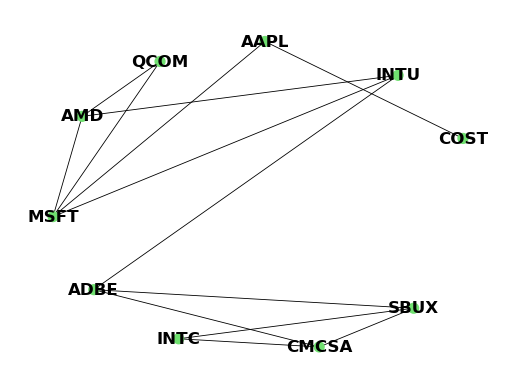

Training Data Shape: torch.Size([408, 11, 20])
Test Data Shape: torch.Size([408, 11, 20])
--- Model Initialization ---
--- Training Begins ---
Day 16 | Epoch 0/40 | Training Loss (MSE): 0.119634
Day 16 | Epoch 5/40 | Training Loss (MSE): 0.015119
Day 16 | Epoch 10/40 | Training Loss (MSE): 0.001501
Day 16 | Epoch 15/40 | Training Loss (MSE): 0.004292
Day 16 | Epoch 20/40 | Training Loss (MSE): 0.002661
Day 16 | Epoch 25/40 | Training Loss (MSE): 0.000833
Day 16 | Epoch 30/40 | Training Loss (MSE): 0.000407
Day 16 | Epoch 35/40 | Training Loss (MSE): 0.000498
Training Completed for Test Day 16 in 5.54 seconds.
Day 16 | Final Test Loss (MSE): 0.000825
MSE for each stock on Test Day 16:
AAPL: 0.000614
MSFT: 0.001993
CMCSA: 0.000054
COST: 0.001828
QCOM: 0.000104
ADBE: 0.000782
SBUX: 0.002564
INTU: 0.000005
AMD: 0.000233
INTC: 0.000076

Real Values in Tabular Form:
Stock  Real Ground Truth (Original)  Real Predicted Values (Original)  Test Day
 AAPL                    149.449997            

c:\ProgramData\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


26
Generated Edge Index for Day 17


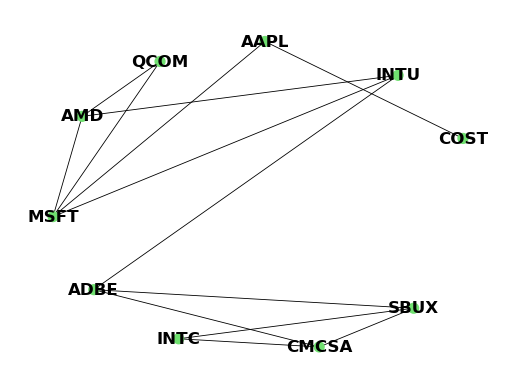

Training Data Shape: torch.Size([408, 11, 20])
Test Data Shape: torch.Size([408, 11, 20])
--- Model Initialization ---
--- Training Begins ---
Day 17 | Epoch 0/40 | Training Loss (MSE): 0.064753
Day 17 | Epoch 5/40 | Training Loss (MSE): 0.011580
Day 17 | Epoch 10/40 | Training Loss (MSE): 0.001817
Day 17 | Epoch 15/40 | Training Loss (MSE): 0.001931
Day 17 | Epoch 20/40 | Training Loss (MSE): 0.000938
Day 17 | Epoch 25/40 | Training Loss (MSE): 0.000286
Day 17 | Epoch 30/40 | Training Loss (MSE): 0.000270
Day 17 | Epoch 35/40 | Training Loss (MSE): 0.000168
Training Completed for Test Day 17 in 5.82 seconds.
Day 17 | Final Test Loss (MSE): 0.000782
MSE for each stock on Test Day 17:
AAPL: 0.001867
MSFT: 0.000144
CMCSA: 0.000790
COST: 0.000377
QCOM: 0.001078
ADBE: 0.000004
SBUX: 0.000821
INTU: 0.002062
AMD: 0.000639
INTC: 0.000035

Real Values in Tabular Form:
Stock  Real Ground Truth (Original)  Real Predicted Values (Original)  Test Day
 AAPL                    152.339996            

c:\ProgramData\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


26
Generated Edge Index for Day 18


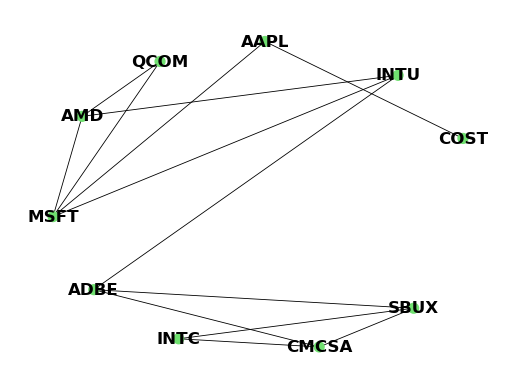

Training Data Shape: torch.Size([408, 11, 20])
Test Data Shape: torch.Size([408, 11, 20])
--- Model Initialization ---
--- Training Begins ---
Day 18 | Epoch 0/40 | Training Loss (MSE): 0.158531
Day 18 | Epoch 5/40 | Training Loss (MSE): 0.040388
Day 18 | Epoch 10/40 | Training Loss (MSE): 0.004055
Day 18 | Epoch 15/40 | Training Loss (MSE): 0.005207
Day 18 | Epoch 20/40 | Training Loss (MSE): 0.003425
Day 18 | Epoch 25/40 | Training Loss (MSE): 0.001530
Day 18 | Epoch 30/40 | Training Loss (MSE): 0.000733
Day 18 | Epoch 35/40 | Training Loss (MSE): 0.000404
Training Completed for Test Day 18 in 5.62 seconds.
Day 18 | Final Test Loss (MSE): 0.003149
MSE for each stock on Test Day 18:
AAPL: 0.004442
MSFT: 0.021312
CMCSA: 0.000023
COST: 0.000430
QCOM: 0.000576
ADBE: 0.000000
SBUX: 0.002759
INTU: 0.001699
AMD: 0.000004
INTC: 0.000246

Real Values in Tabular Form:
Stock  Real Ground Truth (Original)  Real Predicted Values (Original)  Test Day
 AAPL                    149.350006            

c:\ProgramData\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


26
Generated Edge Index for Day 19


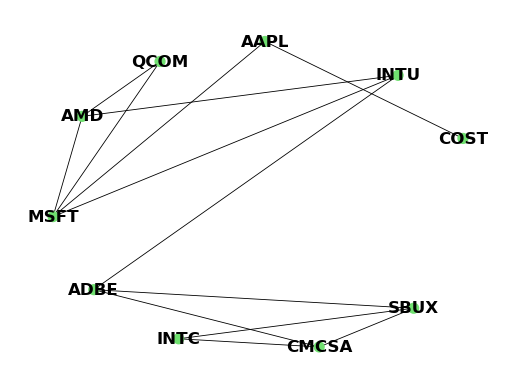

Training Data Shape: torch.Size([408, 11, 20])
Test Data Shape: torch.Size([408, 11, 20])
--- Model Initialization ---
--- Training Begins ---
Day 19 | Epoch 0/40 | Training Loss (MSE): 0.156647
Day 19 | Epoch 5/40 | Training Loss (MSE): 0.055808
Day 19 | Epoch 10/40 | Training Loss (MSE): 0.009276
Day 19 | Epoch 15/40 | Training Loss (MSE): 0.005796
Day 19 | Epoch 20/40 | Training Loss (MSE): 0.001605
Day 19 | Epoch 25/40 | Training Loss (MSE): 0.001664
Day 19 | Epoch 30/40 | Training Loss (MSE): 0.000715
Day 19 | Epoch 35/40 | Training Loss (MSE): 0.000397
Training Completed for Test Day 19 in 6.01 seconds.
Day 19 | Final Test Loss (MSE): 0.001078
MSE for each stock on Test Day 19:
AAPL: 0.004248
MSFT: 0.002217
CMCSA: 0.000041
COST: 0.000148
QCOM: 0.001905
ADBE: 0.000329
SBUX: 0.000269
INTU: 0.000456
AMD: 0.000092
INTC: 0.001079

Real Values in Tabular Form:
Stock  Real Ground Truth (Original)  Real Predicted Values (Original)  Test Day
 AAPL                    144.800003            

c:\ProgramData\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


26
Generated Edge Index for Day 20


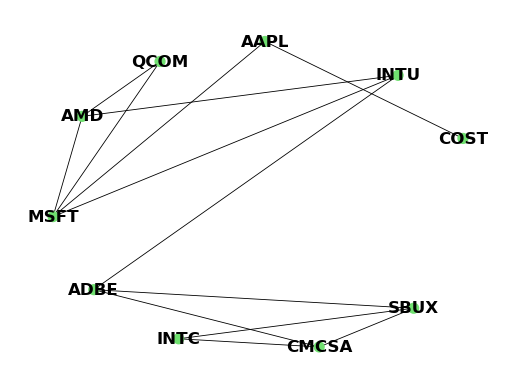

Training Data Shape: torch.Size([408, 11, 20])
Test Data Shape: torch.Size([408, 11, 20])
--- Model Initialization ---
--- Training Begins ---
Day 20 | Epoch 0/40 | Training Loss (MSE): 0.104530
Day 20 | Epoch 5/40 | Training Loss (MSE): 0.019600
Day 20 | Epoch 10/40 | Training Loss (MSE): 0.002486
Day 20 | Epoch 15/40 | Training Loss (MSE): 0.004784
Day 20 | Epoch 20/40 | Training Loss (MSE): 0.001048
Day 20 | Epoch 25/40 | Training Loss (MSE): 0.000818
Day 20 | Epoch 30/40 | Training Loss (MSE): 0.000611
Day 20 | Epoch 35/40 | Training Loss (MSE): 0.000282
Training Completed for Test Day 20 in 5.75 seconds.
Day 20 | Final Test Loss (MSE): 0.004224
MSE for each stock on Test Day 20:
AAPL: 0.019659
MSFT: 0.004498
CMCSA: 0.000000
COST: 0.001548
QCOM: 0.005415
ADBE: 0.000351
SBUX: 0.001330
INTU: 0.000330
AMD: 0.002058
INTC: 0.007053

Real Values in Tabular Form:
Stock  Real Ground Truth (Original)  Real Predicted Values (Original)  Test Day
 AAPL                    155.740005            

c:\ProgramData\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


26
Generated Edge Index for Day 21


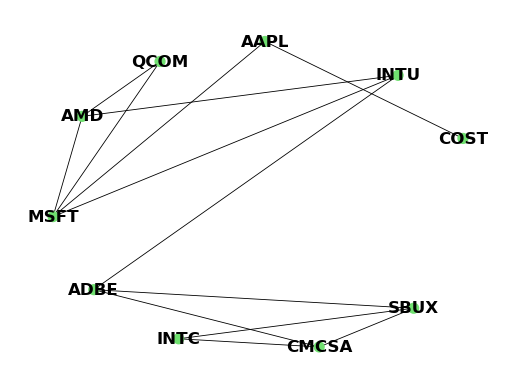

Training Data Shape: torch.Size([408, 11, 20])
Test Data Shape: torch.Size([408, 11, 20])
--- Model Initialization ---
--- Training Begins ---
Day 21 | Epoch 0/40 | Training Loss (MSE): 0.095358
Day 21 | Epoch 5/40 | Training Loss (MSE): 0.020827
Day 21 | Epoch 10/40 | Training Loss (MSE): 0.002406
Day 21 | Epoch 15/40 | Training Loss (MSE): 0.002790
Day 21 | Epoch 20/40 | Training Loss (MSE): 0.001262
Day 21 | Epoch 25/40 | Training Loss (MSE): 0.000513
Day 21 | Epoch 30/40 | Training Loss (MSE): 0.000303
Day 21 | Epoch 35/40 | Training Loss (MSE): 0.000297
Training Completed for Test Day 21 in 5.33 seconds.
Day 21 | Final Test Loss (MSE): 0.000463
MSE for each stock on Test Day 21:
AAPL: 0.001221
MSFT: 0.001264
CMCSA: 0.000002
COST: 0.000250
QCOM: 0.000150
ADBE: 0.000180
SBUX: 0.000131
INTU: 0.000002
AMD: 0.000005
INTC: 0.001422

Real Values in Tabular Form:
Stock  Real Ground Truth (Original)  Real Predicted Values (Original)  Test Day
 AAPL                    153.339996            

c:\ProgramData\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


26
Generated Edge Index for Day 22


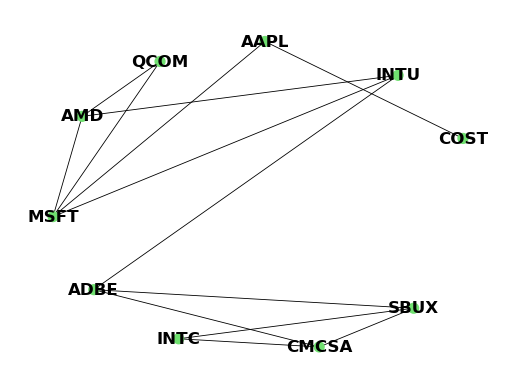

Training Data Shape: torch.Size([408, 11, 20])
Test Data Shape: torch.Size([408, 11, 20])
--- Model Initialization ---
--- Training Begins ---
Day 22 | Epoch 0/40 | Training Loss (MSE): 0.068707
Day 22 | Epoch 5/40 | Training Loss (MSE): 0.005399
Day 22 | Epoch 10/40 | Training Loss (MSE): 0.000991
Day 22 | Epoch 15/40 | Training Loss (MSE): 0.002903
Day 22 | Epoch 20/40 | Training Loss (MSE): 0.000484
Day 22 | Epoch 25/40 | Training Loss (MSE): 0.000492
Day 22 | Epoch 30/40 | Training Loss (MSE): 0.000414
Day 22 | Epoch 35/40 | Training Loss (MSE): 0.000179
Training Completed for Test Day 22 in 5.63 seconds.
Day 22 | Final Test Loss (MSE): 0.001451
MSE for each stock on Test Day 22:
AAPL: 0.002086
MSFT: 0.001534
CMCSA: 0.000023
COST: 0.000309
QCOM: 0.000263
ADBE: 0.000000
SBUX: 0.000287
INTU: 0.009849
AMD: 0.000150
INTC: 0.000008

Real Values in Tabular Form:
Stock  Real Ground Truth (Original)  Real Predicted Values (Original)  Test Day
 AAPL                    150.649994            

c:\ProgramData\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


24
Generated Edge Index for Day 23


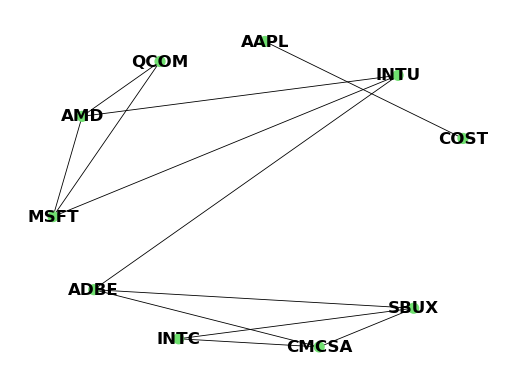

Training Data Shape: torch.Size([408, 11, 20])
Test Data Shape: torch.Size([408, 11, 20])
--- Model Initialization ---
--- Training Begins ---
Day 23 | Epoch 0/40 | Training Loss (MSE): 0.154214
Day 23 | Epoch 5/40 | Training Loss (MSE): 0.043143
Day 23 | Epoch 10/40 | Training Loss (MSE): 0.005759
Day 23 | Epoch 15/40 | Training Loss (MSE): 0.004987
Day 23 | Epoch 20/40 | Training Loss (MSE): 0.002330
Day 23 | Epoch 25/40 | Training Loss (MSE): 0.001016
Day 23 | Epoch 30/40 | Training Loss (MSE): 0.000730
Day 23 | Epoch 35/40 | Training Loss (MSE): 0.000448
Training Completed for Test Day 23 in 5.81 seconds.
Day 23 | Final Test Loss (MSE): 0.002077
MSE for each stock on Test Day 23:
AAPL: 0.005252
MSFT: 0.003036
CMCSA: 0.000012
COST: 0.002542
QCOM: 0.002360
ADBE: 0.003418
SBUX: 0.002794
INTU: 0.000596
AMD: 0.000523
INTC: 0.000233

Real Values in Tabular Form:
Stock  Real Ground Truth (Original)  Real Predicted Values (Original)  Test Day
 AAPL                    145.029999            

c:\ProgramData\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


24
Generated Edge Index for Day 24


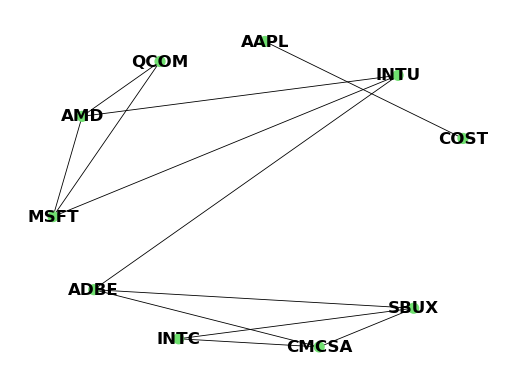

Training Data Shape: torch.Size([408, 11, 20])
Test Data Shape: torch.Size([408, 11, 20])
--- Model Initialization ---
--- Training Begins ---
Day 24 | Epoch 0/40 | Training Loss (MSE): 0.111746
Day 24 | Epoch 5/40 | Training Loss (MSE): 0.042636
Day 24 | Epoch 10/40 | Training Loss (MSE): 0.013261
Day 24 | Epoch 15/40 | Training Loss (MSE): 0.003759
Day 24 | Epoch 20/40 | Training Loss (MSE): 0.002514
Day 24 | Epoch 25/40 | Training Loss (MSE): 0.000911
Day 24 | Epoch 30/40 | Training Loss (MSE): 0.000836
Day 24 | Epoch 35/40 | Training Loss (MSE): 0.000351
Training Completed for Test Day 24 in 5.74 seconds.
Day 24 | Final Test Loss (MSE): 0.002232
MSE for each stock on Test Day 24:
AAPL: 0.003584
MSFT: 0.002258
CMCSA: 0.000630
COST: 0.000016
QCOM: 0.011496
ADBE: 0.003244
SBUX: 0.000006
INTU: 0.000788
AMD: 0.000008
INTC: 0.000291

Real Values in Tabular Form:
Stock  Real Ground Truth (Original)  Real Predicted Values (Original)  Test Day
 AAPL                    138.880005            

c:\ProgramData\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


24
Generated Edge Index for Day 25


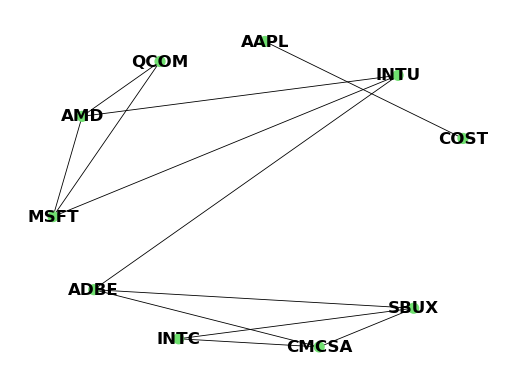

Training Data Shape: torch.Size([408, 11, 20])
Test Data Shape: torch.Size([408, 11, 20])
--- Model Initialization ---
--- Training Begins ---
Day 25 | Epoch 0/40 | Training Loss (MSE): 0.089156
Day 25 | Epoch 5/40 | Training Loss (MSE): 0.012411
Day 25 | Epoch 10/40 | Training Loss (MSE): 0.001939
Day 25 | Epoch 15/40 | Training Loss (MSE): 0.003948
Day 25 | Epoch 20/40 | Training Loss (MSE): 0.000894
Day 25 | Epoch 25/40 | Training Loss (MSE): 0.000848
Day 25 | Epoch 30/40 | Training Loss (MSE): 0.000429
Day 25 | Epoch 35/40 | Training Loss (MSE): 0.000347
Training Completed for Test Day 25 in 5.71 seconds.
Day 25 | Final Test Loss (MSE): 0.002275
MSE for each stock on Test Day 25:
AAPL: 0.000082
MSFT: 0.004031
CMCSA: 0.000032
COST: 0.000001
QCOM: 0.002667
ADBE: 0.000079
SBUX: 0.014670
INTU: 0.000112
AMD: 0.000123
INTC: 0.000954

Real Values in Tabular Form:
Stock  Real Ground Truth (Original)  Real Predicted Values (Original)  Test Day
 AAPL                    138.380005            

c:\ProgramData\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


24
Generated Edge Index for Day 26


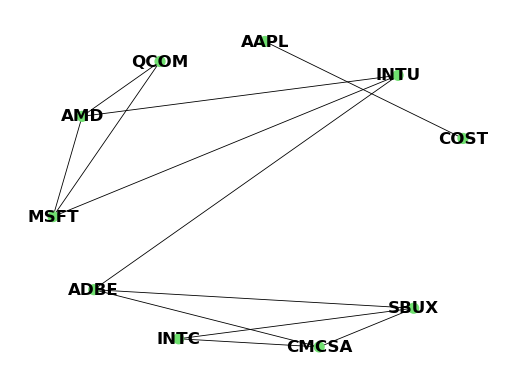

Training Data Shape: torch.Size([408, 11, 20])
Test Data Shape: torch.Size([408, 11, 20])
--- Model Initialization ---
--- Training Begins ---
Day 26 | Epoch 0/40 | Training Loss (MSE): 0.041891
Day 26 | Epoch 5/40 | Training Loss (MSE): 0.005294
Day 26 | Epoch 10/40 | Training Loss (MSE): 0.002171
Day 26 | Epoch 15/40 | Training Loss (MSE): 0.000607
Day 26 | Epoch 20/40 | Training Loss (MSE): 0.000472
Day 26 | Epoch 25/40 | Training Loss (MSE): 0.000288
Day 26 | Epoch 30/40 | Training Loss (MSE): 0.000136
Day 26 | Epoch 35/40 | Training Loss (MSE): 0.000082
Training Completed for Test Day 26 in 5.94 seconds.
Day 26 | Final Test Loss (MSE): 0.000717
MSE for each stock on Test Day 26:
AAPL: 0.000134
MSFT: 0.001983
CMCSA: 0.000336
COST: 0.000000
QCOM: 0.000865
ADBE: 0.000952
SBUX: 0.001474
INTU: 0.000771
AMD: 0.000642
INTC: 0.000014

Real Values in Tabular Form:
Stock  Real Ground Truth (Original)  Real Predicted Values (Original)  Test Day
 AAPL                    138.919998            

c:\ProgramData\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


26
Generated Edge Index for Day 27


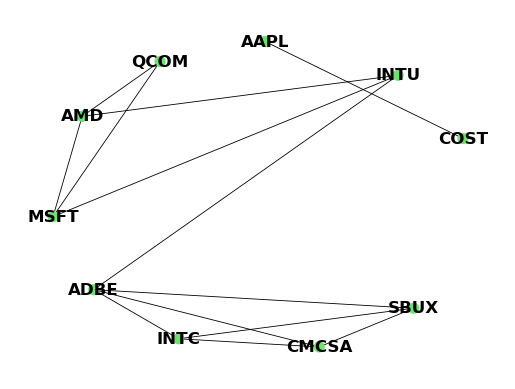

Training Data Shape: torch.Size([408, 11, 20])
Test Data Shape: torch.Size([408, 11, 20])
--- Model Initialization ---
--- Training Begins ---
Day 27 | Epoch 0/40 | Training Loss (MSE): 0.088730
Day 27 | Epoch 5/40 | Training Loss (MSE): 0.019295
Day 27 | Epoch 10/40 | Training Loss (MSE): 0.001062
Day 27 | Epoch 15/40 | Training Loss (MSE): 0.003446
Day 27 | Epoch 20/40 | Training Loss (MSE): 0.001030
Day 27 | Epoch 25/40 | Training Loss (MSE): 0.000241
Day 27 | Epoch 30/40 | Training Loss (MSE): 0.000470
Day 27 | Epoch 35/40 | Training Loss (MSE): 0.000323
Training Completed for Test Day 27 in 5.70 seconds.
Day 27 | Final Test Loss (MSE): 0.000407
MSE for each stock on Test Day 27:
AAPL: 0.000039
MSFT: 0.000002
CMCSA: 0.000153
COST: 0.000162
QCOM: 0.000722
ADBE: 0.000014
SBUX: 0.001183
INTU: 0.001725
AMD: 0.000066
INTC: 0.000003

Real Values in Tabular Form:
Stock  Real Ground Truth (Original)  Real Predicted Values (Original)  Test Day
 AAPL                    139.500000            

c:\ProgramData\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


26
Generated Edge Index for Day 28


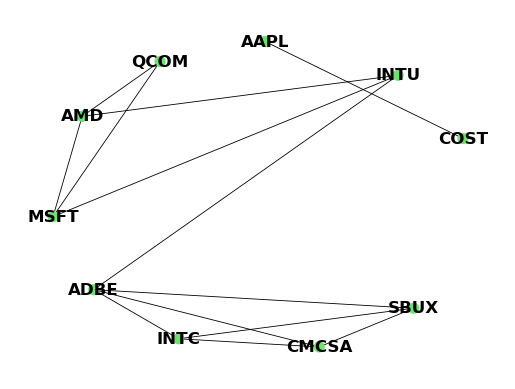

Training Data Shape: torch.Size([408, 11, 20])
Test Data Shape: torch.Size([408, 11, 20])
--- Model Initialization ---
--- Training Begins ---
Day 28 | Epoch 0/40 | Training Loss (MSE): 0.113131
Day 28 | Epoch 5/40 | Training Loss (MSE): 0.044566
Day 28 | Epoch 10/40 | Training Loss (MSE): 0.003333
Day 28 | Epoch 15/40 | Training Loss (MSE): 0.004898
Day 28 | Epoch 20/40 | Training Loss (MSE): 0.001722
Day 28 | Epoch 25/40 | Training Loss (MSE): 0.000799
Day 28 | Epoch 30/40 | Training Loss (MSE): 0.000372
Day 28 | Epoch 35/40 | Training Loss (MSE): 0.000311
Training Completed for Test Day 28 in 5.93 seconds.
Day 28 | Final Test Loss (MSE): 0.001101
MSE for each stock on Test Day 28:
AAPL: 0.004443
MSFT: 0.001755
CMCSA: 0.000284
COST: 0.000748
QCOM: 0.000004
ADBE: 0.000032
SBUX: 0.000063
INTU: 0.002378
AMD: 0.000599
INTC: 0.000708

Real Values in Tabular Form:
Stock  Real Ground Truth (Original)  Real Predicted Values (Original)  Test Day
 AAPL                    134.869995            

c:\ProgramData\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


28
Generated Edge Index for Day 29


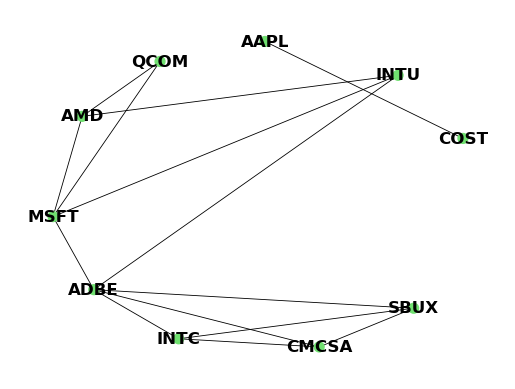

Training Data Shape: torch.Size([408, 11, 20])
Test Data Shape: torch.Size([408, 11, 20])
--- Model Initialization ---
--- Training Begins ---
Day 29 | Epoch 0/40 | Training Loss (MSE): 0.069934
Day 29 | Epoch 5/40 | Training Loss (MSE): 0.011909
Day 29 | Epoch 10/40 | Training Loss (MSE): 0.003571
Day 29 | Epoch 15/40 | Training Loss (MSE): 0.001412
Day 29 | Epoch 20/40 | Training Loss (MSE): 0.000636
Day 29 | Epoch 25/40 | Training Loss (MSE): 0.000548
Day 29 | Epoch 30/40 | Training Loss (MSE): 0.000290
Day 29 | Epoch 35/40 | Training Loss (MSE): 0.000091
Training Completed for Test Day 29 in 5.28 seconds.
Day 29 | Final Test Loss (MSE): 0.011816
MSE for each stock on Test Day 29:
AAPL: 0.032076
MSFT: 0.020006
CMCSA: 0.001704
COST: 0.007394
QCOM: 0.012946
ADBE: 0.005121
SBUX: 0.009953
INTU: 0.015693
AMD: 0.010416
INTC: 0.002855

Real Values in Tabular Form:
Stock  Real Ground Truth (Original)  Real Predicted Values (Original)  Test Day
 AAPL                    146.869995            

c:\ProgramData\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


30
Generated Edge Index for Day 30


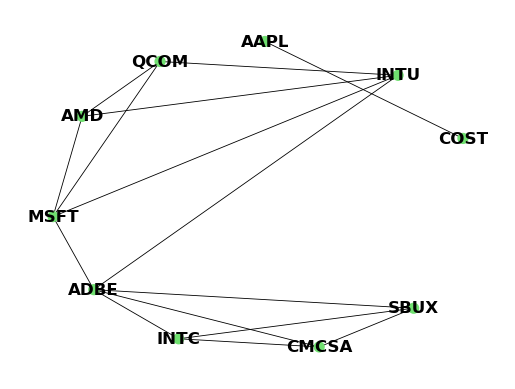

Training Data Shape: torch.Size([408, 11, 20])
Test Data Shape: torch.Size([408, 11, 20])
--- Model Initialization ---
--- Training Begins ---
Day 30 | Epoch 0/40 | Training Loss (MSE): 0.177907
Day 30 | Epoch 5/40 | Training Loss (MSE): 0.068192
Day 30 | Epoch 10/40 | Training Loss (MSE): 0.015144
Day 30 | Epoch 15/40 | Training Loss (MSE): 0.005487
Day 30 | Epoch 20/40 | Training Loss (MSE): 0.003764
Day 30 | Epoch 25/40 | Training Loss (MSE): 0.001770
Day 30 | Epoch 30/40 | Training Loss (MSE): 0.000348
Day 30 | Epoch 35/40 | Training Loss (MSE): 0.000879
Training Completed for Test Day 30 in 5.36 seconds.
Day 30 | Final Test Loss (MSE): 0.001058
MSE for each stock on Test Day 30:
AAPL: 0.000500
MSFT: 0.000605
CMCSA: 0.001945
COST: 0.000123
QCOM: 0.000511
ADBE: 0.000430
SBUX: 0.000165
INTU: 0.000051
AMD: 0.005885
INTC: 0.000364

Real Values in Tabular Form:
Stock  Real Ground Truth (Original)  Real Predicted Values (Original)  Test Day
 AAPL                    149.699997            

c:\ProgramData\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


30
Generated Edge Index for Day 31


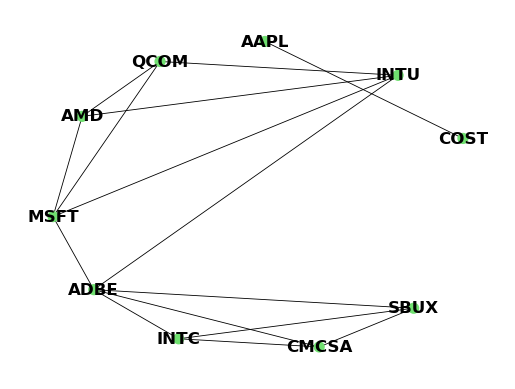

Training Data Shape: torch.Size([408, 11, 20])
Test Data Shape: torch.Size([408, 11, 20])
--- Model Initialization ---
--- Training Begins ---
Day 31 | Epoch 0/40 | Training Loss (MSE): 0.143059
Day 31 | Epoch 5/40 | Training Loss (MSE): 0.053817
Day 31 | Epoch 10/40 | Training Loss (MSE): 0.011138
Day 31 | Epoch 15/40 | Training Loss (MSE): 0.006474
Day 31 | Epoch 20/40 | Training Loss (MSE): 0.001586
Day 31 | Epoch 25/40 | Training Loss (MSE): 0.002156
Day 31 | Epoch 30/40 | Training Loss (MSE): 0.000211
Day 31 | Epoch 35/40 | Training Loss (MSE): 0.000710
Training Completed for Test Day 31 in 5.74 seconds.
Day 31 | Final Test Loss (MSE): 0.000733
MSE for each stock on Test Day 31:
AAPL: 0.002658
MSFT: 0.001411
CMCSA: 0.000061
COST: 0.000805
QCOM: 0.000033
ADBE: 0.000170
SBUX: 0.001046
INTU: 0.001019
AMD: 0.000126
INTC: 0.000001

Real Values in Tabular Form:
Stock  Real Ground Truth (Original)  Real Predicted Values (Original)  Test Day
 AAPL                    148.279999            

c:\ProgramData\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


30
Generated Edge Index for Day 32


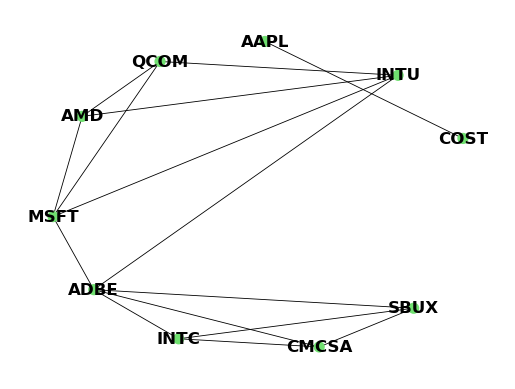

Training Data Shape: torch.Size([408, 11, 20])
Test Data Shape: torch.Size([408, 11, 20])
--- Model Initialization ---
--- Training Begins ---
Day 32 | Epoch 0/40 | Training Loss (MSE): 0.164429
Day 32 | Epoch 5/40 | Training Loss (MSE): 0.051113
Day 32 | Epoch 10/40 | Training Loss (MSE): 0.008981
Day 32 | Epoch 15/40 | Training Loss (MSE): 0.004615
Day 32 | Epoch 20/40 | Training Loss (MSE): 0.004138
Day 32 | Epoch 25/40 | Training Loss (MSE): 0.001798
Day 32 | Epoch 30/40 | Training Loss (MSE): 0.000190
Day 32 | Epoch 35/40 | Training Loss (MSE): 0.000308
Training Completed for Test Day 32 in 5.70 seconds.
Day 32 | Final Test Loss (MSE): 0.001099
MSE for each stock on Test Day 32:
AAPL: 0.000018
MSFT: 0.000050
CMCSA: 0.000094
COST: 0.003808
QCOM: 0.001722
ADBE: 0.000043
SBUX: 0.000001
INTU: 0.000199
AMD: 0.001541
INTC: 0.003513

Real Values in Tabular Form:
Stock  Real Ground Truth (Original)  Real Predicted Values (Original)  Test Day
 AAPL                    150.039993            

c:\ProgramData\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


30
Generated Edge Index for Day 33


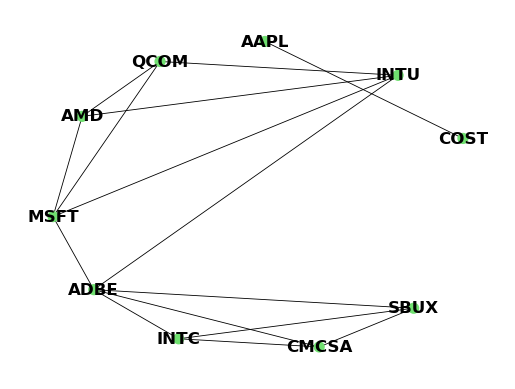

Training Data Shape: torch.Size([408, 11, 20])
Test Data Shape: torch.Size([408, 11, 20])
--- Model Initialization ---
--- Training Begins ---
Day 33 | Epoch 0/40 | Training Loss (MSE): 0.148058
Day 33 | Epoch 5/40 | Training Loss (MSE): 0.032601
Day 33 | Epoch 10/40 | Training Loss (MSE): 0.001179
Day 33 | Epoch 15/40 | Training Loss (MSE): 0.006806
Day 33 | Epoch 20/40 | Training Loss (MSE): 0.002906
Day 33 | Epoch 25/40 | Training Loss (MSE): 0.000289
Day 33 | Epoch 30/40 | Training Loss (MSE): 0.000868
Day 33 | Epoch 35/40 | Training Loss (MSE): 0.000671
Training Completed for Test Day 33 in 5.90 seconds.
Day 33 | Final Test Loss (MSE): 0.001600
MSE for each stock on Test Day 33:
AAPL: 0.001876
MSFT: 0.000000
CMCSA: 0.000341
COST: 0.000103
QCOM: 0.009470
ADBE: 0.000530
SBUX: 0.000037
INTU: 0.000548
AMD: 0.002203
INTC: 0.000893

Real Values in Tabular Form:
Stock  Real Ground Truth (Original)  Real Predicted Values (Original)  Test Day
 AAPL                    148.789993            

c:\ProgramData\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


30
Generated Edge Index for Day 34


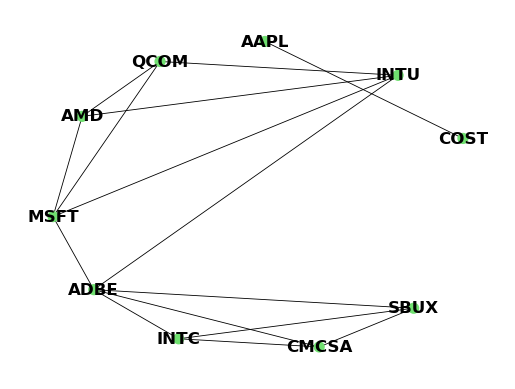

Training Data Shape: torch.Size([408, 11, 20])
Test Data Shape: torch.Size([408, 11, 20])
--- Model Initialization ---
--- Training Begins ---
Day 34 | Epoch 0/40 | Training Loss (MSE): 0.090311
Day 34 | Epoch 5/40 | Training Loss (MSE): 0.016210
Day 34 | Epoch 10/40 | Training Loss (MSE): 0.002137
Day 34 | Epoch 15/40 | Training Loss (MSE): 0.002654
Day 34 | Epoch 20/40 | Training Loss (MSE): 0.000982
Day 34 | Epoch 25/40 | Training Loss (MSE): 0.000383
Day 34 | Epoch 30/40 | Training Loss (MSE): 0.000346
Day 34 | Epoch 35/40 | Training Loss (MSE): 0.000215
Training Completed for Test Day 34 in 5.74 seconds.
Day 34 | Final Test Loss (MSE): 0.000552
MSE for each stock on Test Day 34:
AAPL: 0.001166
MSFT: 0.000167
CMCSA: 0.000134
COST: 0.000128
QCOM: 0.000762
ADBE: 0.000138
SBUX: 0.000452
INTU: 0.001957
AMD: 0.000570
INTC: 0.000052

Real Values in Tabular Form:
Stock  Real Ground Truth (Original)  Real Predicted Values (Original)  Test Day
 AAPL                    150.720001            

c:\ProgramData\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


30
Generated Edge Index for Day 35


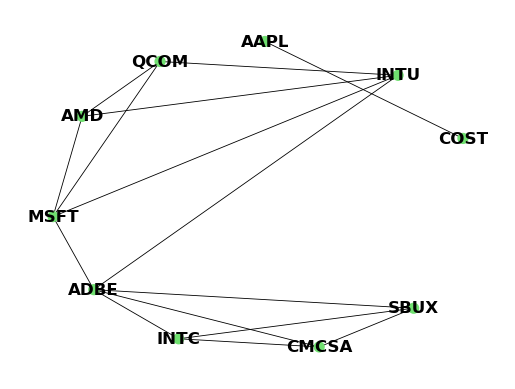

Training Data Shape: torch.Size([408, 11, 20])
Test Data Shape: torch.Size([408, 11, 20])
--- Model Initialization ---
--- Training Begins ---
Day 35 | Epoch 0/40 | Training Loss (MSE): 0.201348
Day 35 | Epoch 5/40 | Training Loss (MSE): 0.096900
Day 35 | Epoch 10/40 | Training Loss (MSE): 0.018269
Day 35 | Epoch 15/40 | Training Loss (MSE): 0.010101
Day 35 | Epoch 20/40 | Training Loss (MSE): 0.003363
Day 35 | Epoch 25/40 | Training Loss (MSE): 0.001544
Day 35 | Epoch 30/40 | Training Loss (MSE): 0.001272
Day 35 | Epoch 35/40 | Training Loss (MSE): 0.000734
Training Completed for Test Day 35 in 5.70 seconds.
Day 35 | Final Test Loss (MSE): 0.000191
MSE for each stock on Test Day 35:
AAPL: 0.000623
MSFT: 0.000247
CMCSA: 0.000062
COST: 0.000346
QCOM: 0.000007
ADBE: 0.000060
SBUX: 0.000233
INTU: 0.000145
AMD: 0.000000
INTC: 0.000188

Real Values in Tabular Form:
Stock  Real Ground Truth (Original)  Real Predicted Values (Original)  Test Day
 AAPL                    151.289993            

c:\ProgramData\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


30
Generated Edge Index for Day 36


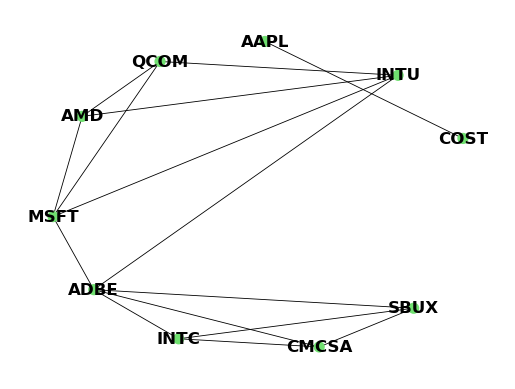

Training Data Shape: torch.Size([408, 11, 20])
Test Data Shape: torch.Size([408, 11, 20])
--- Model Initialization ---
--- Training Begins ---
Day 36 | Epoch 0/40 | Training Loss (MSE): 0.090064
Day 36 | Epoch 5/40 | Training Loss (MSE): 0.011481
Day 36 | Epoch 10/40 | Training Loss (MSE): 0.003236
Day 36 | Epoch 15/40 | Training Loss (MSE): 0.002132
Day 36 | Epoch 20/40 | Training Loss (MSE): 0.000771
Day 36 | Epoch 25/40 | Training Loss (MSE): 0.000622
Day 36 | Epoch 30/40 | Training Loss (MSE): 0.000441
Day 36 | Epoch 35/40 | Training Loss (MSE): 0.000151
Training Completed for Test Day 36 in 5.82 seconds.
Day 36 | Final Test Loss (MSE): 0.000788
MSE for each stock on Test Day 36:
AAPL: 0.002484
MSFT: 0.000029
CMCSA: 0.000286
COST: 0.000032
QCOM: 0.001501
ADBE: 0.000348
SBUX: 0.000463
INTU: 0.000292
AMD: 0.000965
INTC: 0.001477

Real Values in Tabular Form:
Stock  Real Ground Truth (Original)  Real Predicted Values (Original)  Test Day
 AAPL                    148.009995            

c:\ProgramData\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


30
Generated Edge Index for Day 37


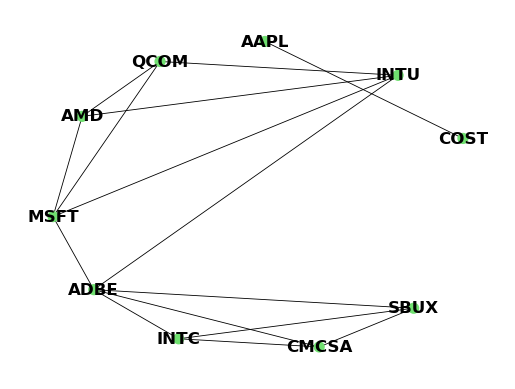

Training Data Shape: torch.Size([408, 11, 20])
Test Data Shape: torch.Size([408, 11, 20])
--- Model Initialization ---
--- Training Begins ---
Day 37 | Epoch 0/40 | Training Loss (MSE): 0.185976
Day 37 | Epoch 5/40 | Training Loss (MSE): 0.044337
Day 37 | Epoch 10/40 | Training Loss (MSE): 0.004721
Day 37 | Epoch 15/40 | Training Loss (MSE): 0.007911
Day 37 | Epoch 20/40 | Training Loss (MSE): 0.001948
Day 37 | Epoch 25/40 | Training Loss (MSE): 0.001798
Day 37 | Epoch 30/40 | Training Loss (MSE): 0.000830
Day 37 | Epoch 35/40 | Training Loss (MSE): 0.000467
Training Completed for Test Day 37 in 5.92 seconds.
Day 37 | Final Test Loss (MSE): 0.001583
MSE for each stock on Test Day 37:
AAPL: 0.003295
MSFT: 0.002535
CMCSA: 0.000041
COST: 0.000018
QCOM: 0.001645
ADBE: 0.001161
SBUX: 0.000133
INTU: 0.006330
AMD: 0.000651
INTC: 0.000021

Real Values in Tabular Form:
Stock  Real Ground Truth (Original)  Real Predicted Values (Original)  Test Day
 AAPL                    150.179993            

c:\ProgramData\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


30
Generated Edge Index for Day 38


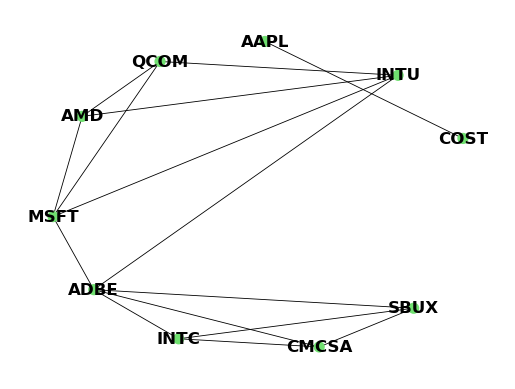

Training Data Shape: torch.Size([408, 11, 20])
Test Data Shape: torch.Size([408, 11, 20])
--- Model Initialization ---
--- Training Begins ---
Day 38 | Epoch 0/40 | Training Loss (MSE): 0.161839
Day 38 | Epoch 5/40 | Training Loss (MSE): 0.047271
Day 38 | Epoch 10/40 | Training Loss (MSE): 0.005883
Day 38 | Epoch 15/40 | Training Loss (MSE): 0.004900
Day 38 | Epoch 20/40 | Training Loss (MSE): 0.004274
Day 38 | Epoch 25/40 | Training Loss (MSE): 0.000906
Day 38 | Epoch 30/40 | Training Loss (MSE): 0.000566
Day 38 | Epoch 35/40 | Training Loss (MSE): 0.000589
Training Completed for Test Day 38 in 5.73 seconds.
Day 38 | Final Test Loss (MSE): 0.000681
MSE for each stock on Test Day 38:
AAPL: 0.001168
MSFT: 0.004590
CMCSA: 0.000251
COST: 0.000039
QCOM: 0.000034
ADBE: 0.000450
SBUX: 0.000077
INTU: 0.000001
AMD: 0.000202
INTC: 0.000002

Real Values in Tabular Form:
Stock  Real Ground Truth (Original)  Real Predicted Values (Original)  Test Day
 AAPL                    151.070007            

c:\ProgramData\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


30
Generated Edge Index for Day 39


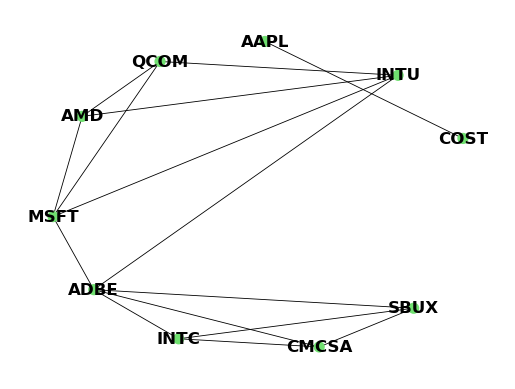

Training Data Shape: torch.Size([408, 11, 20])
Test Data Shape: torch.Size([408, 11, 20])
--- Model Initialization ---
--- Training Begins ---
Day 39 | Epoch 0/40 | Training Loss (MSE): 0.207364
Day 39 | Epoch 5/40 | Training Loss (MSE): 0.075613
Day 39 | Epoch 10/40 | Training Loss (MSE): 0.008618
Day 39 | Epoch 15/40 | Training Loss (MSE): 0.009147
Day 39 | Epoch 20/40 | Training Loss (MSE): 0.003891
Day 39 | Epoch 25/40 | Training Loss (MSE): 0.001147
Day 39 | Epoch 30/40 | Training Loss (MSE): 0.001225
Day 39 | Epoch 35/40 | Training Loss (MSE): 0.000740
Training Completed for Test Day 39 in 7.00 seconds.
Day 39 | Final Test Loss (MSE): 0.000289
MSE for each stock on Test Day 39:
AAPL: 0.000481
MSFT: 0.000002
CMCSA: 0.000181
COST: 0.000845
QCOM: 0.000039
ADBE: 0.000220
SBUX: 0.000081
INTU: 0.000511
AMD: 0.000280
INTC: 0.000253

Real Values in Tabular Form:
Stock  Real Ground Truth (Original)  Real Predicted Values (Original)  Test Day
 AAPL                    148.110001            

c:\ProgramData\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


30
Generated Edge Index for Day 40


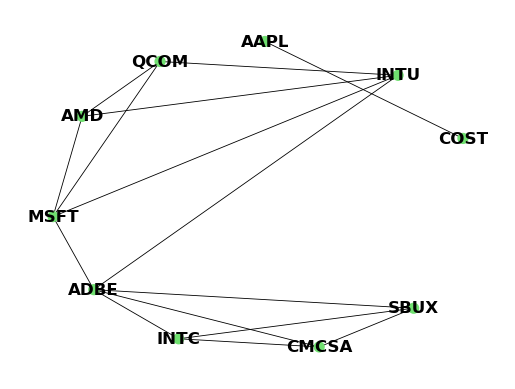

Training Data Shape: torch.Size([408, 11, 20])
Test Data Shape: torch.Size([408, 11, 20])
--- Model Initialization ---
--- Training Begins ---
Day 40 | Epoch 0/40 | Training Loss (MSE): 0.213626
Day 40 | Epoch 5/40 | Training Loss (MSE): 0.048342
Day 40 | Epoch 10/40 | Training Loss (MSE): 0.005934
Day 40 | Epoch 15/40 | Training Loss (MSE): 0.010423
Day 40 | Epoch 20/40 | Training Loss (MSE): 0.001491
Day 40 | Epoch 25/40 | Training Loss (MSE): 0.002636
Day 40 | Epoch 30/40 | Training Loss (MSE): 0.000655
Day 40 | Epoch 35/40 | Training Loss (MSE): 0.000922
Training Completed for Test Day 40 in 5.64 seconds.
Day 40 | Final Test Loss (MSE): 0.001661
MSE for each stock on Test Day 40:
AAPL: 0.003172
MSFT: 0.006172
CMCSA: 0.000078
COST: 0.000967
QCOM: 0.001904
ADBE: 0.001071
SBUX: 0.002044
INTU: 0.000780
AMD: 0.000418
INTC: 0.000008

Real Values in Tabular Form:
Stock  Real Ground Truth (Original)  Real Predicted Values (Original)  Test Day
 AAPL                    144.220001            

c:\ProgramData\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


30
Generated Edge Index for Day 41


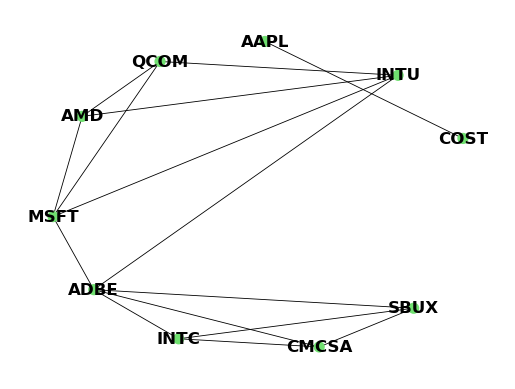

Training Data Shape: torch.Size([408, 11, 20])
Test Data Shape: torch.Size([408, 11, 20])
--- Model Initialization ---
--- Training Begins ---
Day 41 | Epoch 0/40 | Training Loss (MSE): 0.117736
Day 41 | Epoch 5/40 | Training Loss (MSE): 0.026751
Day 41 | Epoch 10/40 | Training Loss (MSE): 0.002769
Day 41 | Epoch 15/40 | Training Loss (MSE): 0.004821
Day 41 | Epoch 20/40 | Training Loss (MSE): 0.000692
Day 41 | Epoch 25/40 | Training Loss (MSE): 0.001021
Day 41 | Epoch 30/40 | Training Loss (MSE): 0.000393
Day 41 | Epoch 35/40 | Training Loss (MSE): 0.000337
Training Completed for Test Day 41 in 5.72 seconds.
Day 41 | Final Test Loss (MSE): 0.000406
MSE for each stock on Test Day 41:
AAPL: 0.002661
MSFT: 0.000319
CMCSA: 0.000213
COST: 0.000487
QCOM: 0.000129
ADBE: 0.000042
SBUX: 0.000059
INTU: 0.000045
AMD: 0.000108
INTC: 0.000001

Real Values in Tabular Form:
Stock  Real Ground Truth (Original)  Real Predicted Values (Original)  Test Day
 AAPL                    141.169998            

c:\ProgramData\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


30
Generated Edge Index for Day 42


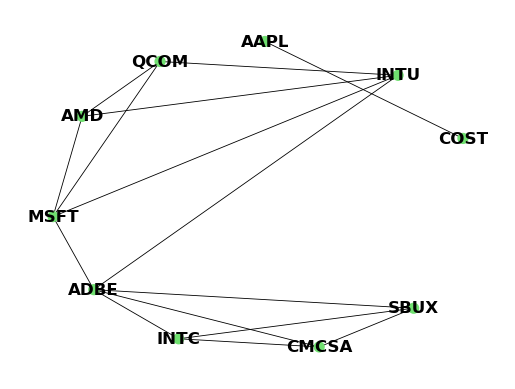

Training Data Shape: torch.Size([408, 11, 20])
Test Data Shape: torch.Size([408, 11, 20])
--- Model Initialization ---
--- Training Begins ---
Day 42 | Epoch 0/40 | Training Loss (MSE): 0.205216
Day 42 | Epoch 5/40 | Training Loss (MSE): 0.097923
Day 42 | Epoch 10/40 | Training Loss (MSE): 0.016398
Day 42 | Epoch 15/40 | Training Loss (MSE): 0.004082
Day 42 | Epoch 20/40 | Training Loss (MSE): 0.005832
Day 42 | Epoch 25/40 | Training Loss (MSE): 0.000725
Day 42 | Epoch 30/40 | Training Loss (MSE): 0.001650
Day 42 | Epoch 35/40 | Training Loss (MSE): 0.000485
Training Completed for Test Day 42 in 6.31 seconds.
Day 42 | Final Test Loss (MSE): 0.006773
MSE for each stock on Test Day 42:
AAPL: 0.010837
MSFT: 0.012508
CMCSA: 0.004132
COST: 0.003143
QCOM: 0.008135
ADBE: 0.000645
SBUX: 0.011380
INTU: 0.012243
AMD: 0.002261
INTC: 0.002446

Real Values in Tabular Form:
Stock  Real Ground Truth (Original)  Real Predicted Values (Original)  Test Day
 AAPL                    148.029984            

c:\ProgramData\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


28
Generated Edge Index for Day 43


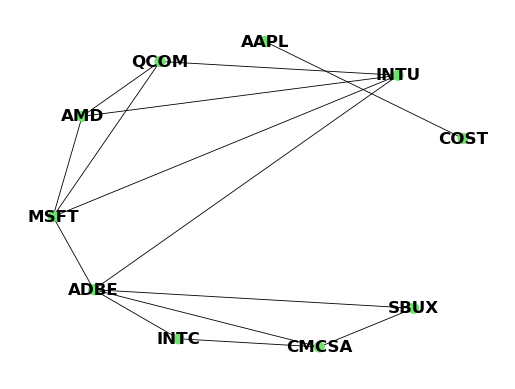

Training Data Shape: torch.Size([408, 11, 20])
Test Data Shape: torch.Size([408, 11, 20])
--- Model Initialization ---
--- Training Begins ---
Day 43 | Epoch 0/40 | Training Loss (MSE): 0.133156
Day 43 | Epoch 5/40 | Training Loss (MSE): 0.051509
Day 43 | Epoch 10/40 | Training Loss (MSE): 0.010975
Day 43 | Epoch 15/40 | Training Loss (MSE): 0.002225
Day 43 | Epoch 20/40 | Training Loss (MSE): 0.003428
Day 43 | Epoch 25/40 | Training Loss (MSE): 0.001024
Day 43 | Epoch 30/40 | Training Loss (MSE): 0.000254
Day 43 | Epoch 35/40 | Training Loss (MSE): 0.000467
Training Completed for Test Day 43 in 5.94 seconds.
Day 43 | Final Test Loss (MSE): 0.001729
MSE for each stock on Test Day 43:
AAPL: 0.000100
MSFT: 0.000153
CMCSA: 0.001352
COST: 0.011275
QCOM: 0.000013
ADBE: 0.000005
SBUX: 0.001147
INTU: 0.002865
AMD: 0.000349
INTC: 0.000035

Real Values in Tabular Form:
Stock  Real Ground Truth (Original)  Real Predicted Values (Original)  Test Day
 AAPL                    148.309998            

c:\ProgramData\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


28
Generated Edge Index for Day 44


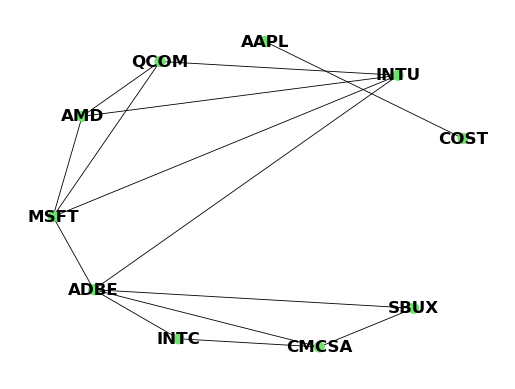

Training Data Shape: torch.Size([408, 11, 20])
Test Data Shape: torch.Size([408, 11, 20])
--- Model Initialization ---
--- Training Begins ---
Day 44 | Epoch 0/40 | Training Loss (MSE): 0.124396
Day 44 | Epoch 5/40 | Training Loss (MSE): 0.022016
Day 44 | Epoch 10/40 | Training Loss (MSE): 0.000320
Day 44 | Epoch 15/40 | Training Loss (MSE): 0.005663
Day 44 | Epoch 20/40 | Training Loss (MSE): 0.002160
Day 44 | Epoch 25/40 | Training Loss (MSE): 0.000285
Day 44 | Epoch 30/40 | Training Loss (MSE): 0.000801
Day 44 | Epoch 35/40 | Training Loss (MSE): 0.000547
Training Completed for Test Day 44 in 5.63 seconds.
Day 44 | Final Test Loss (MSE): 0.000734
MSE for each stock on Test Day 44:
AAPL: 0.000236
MSFT: 0.000049
CMCSA: 0.000466
COST: 0.001581
QCOM: 0.000561
ADBE: 0.000085
SBUX: 0.000698
INTU: 0.002403
AMD: 0.000934
INTC: 0.000326

Real Values in Tabular Form:
Stock  Real Ground Truth (Original)  Real Predicted Values (Original)  Test Day
 AAPL                    147.809998            

c:\ProgramData\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


28
Generated Edge Index for Day 45


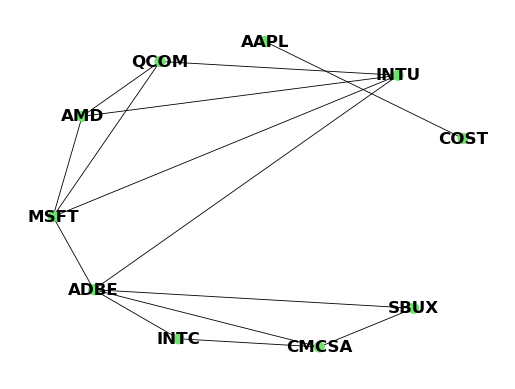

Training Data Shape: torch.Size([408, 11, 20])
Test Data Shape: torch.Size([408, 11, 20])
--- Model Initialization ---
--- Training Begins ---
Day 45 | Epoch 0/40 | Training Loss (MSE): 0.155285
Day 45 | Epoch 5/40 | Training Loss (MSE): 0.039259
Day 45 | Epoch 10/40 | Training Loss (MSE): 0.003263
Day 45 | Epoch 15/40 | Training Loss (MSE): 0.006121
Day 45 | Epoch 20/40 | Training Loss (MSE): 0.002655
Day 45 | Epoch 25/40 | Training Loss (MSE): 0.000254
Day 45 | Epoch 30/40 | Training Loss (MSE): 0.001019
Day 45 | Epoch 35/40 | Training Loss (MSE): 0.000454
Training Completed for Test Day 45 in 6.56 seconds.
Day 45 | Final Test Loss (MSE): 0.000751
MSE for each stock on Test Day 45:
AAPL: 0.000088
MSFT: 0.002310
CMCSA: 0.000001
COST: 0.000109
QCOM: 0.000709
ADBE: 0.000502
SBUX: 0.000764
INTU: 0.002659
AMD: 0.000348
INTC: 0.000021

Real Values in Tabular Form:
Stock  Real Ground Truth (Original)  Real Predicted Values (Original)  Test Day
 AAPL                    146.630005            

c:\ProgramData\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


28
Generated Edge Index for Day 46


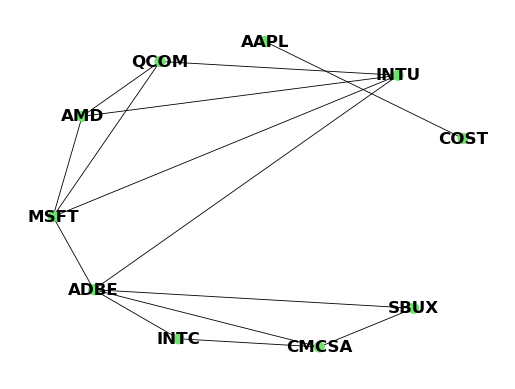

Training Data Shape: torch.Size([408, 11, 20])
Test Data Shape: torch.Size([408, 11, 20])
--- Model Initialization ---
--- Training Begins ---
Day 46 | Epoch 0/40 | Training Loss (MSE): 0.102328
Day 46 | Epoch 5/40 | Training Loss (MSE): 0.029943
Day 46 | Epoch 10/40 | Training Loss (MSE): 0.003668
Day 46 | Epoch 15/40 | Training Loss (MSE): 0.003995
Day 46 | Epoch 20/40 | Training Loss (MSE): 0.001833
Day 46 | Epoch 25/40 | Training Loss (MSE): 0.000362
Day 46 | Epoch 30/40 | Training Loss (MSE): 0.000584
Day 46 | Epoch 35/40 | Training Loss (MSE): 0.000365
Training Completed for Test Day 46 in 5.74 seconds.
Day 46 | Final Test Loss (MSE): 0.001152
MSE for each stock on Test Day 46:
AAPL: 0.003313
MSFT: 0.000995
CMCSA: 0.000165
COST: 0.001706
QCOM: 0.002330
ADBE: 0.000444
SBUX: 0.000780
INTU: 0.000011
AMD: 0.001134
INTC: 0.000643

Real Values in Tabular Form:
Stock  Real Ground Truth (Original)  Real Predicted Values (Original)  Test Day
 AAPL                    142.910004            

c:\ProgramData\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


28
Generated Edge Index for Day 47


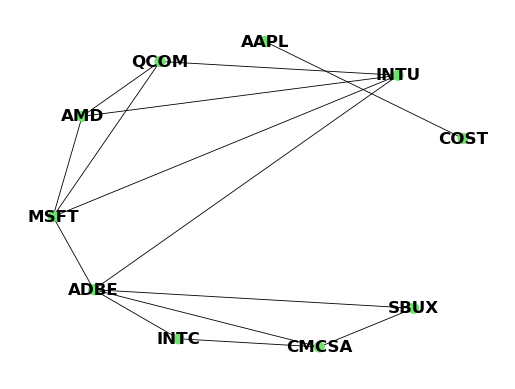

Training Data Shape: torch.Size([408, 11, 20])
Test Data Shape: torch.Size([408, 11, 20])
--- Model Initialization ---
--- Training Begins ---
Day 47 | Epoch 0/40 | Training Loss (MSE): 0.091302
Day 47 | Epoch 5/40 | Training Loss (MSE): 0.008216
Day 47 | Epoch 10/40 | Training Loss (MSE): 0.001947
Day 47 | Epoch 15/40 | Training Loss (MSE): 0.002948
Day 47 | Epoch 20/40 | Training Loss (MSE): 0.001018
Day 47 | Epoch 25/40 | Training Loss (MSE): 0.000423
Day 47 | Epoch 30/40 | Training Loss (MSE): 0.000579
Day 47 | Epoch 35/40 | Training Loss (MSE): 0.000157
Training Completed for Test Day 47 in 6.23 seconds.
Day 47 | Final Test Loss (MSE): 0.000417
MSE for each stock on Test Day 47:
AAPL: 0.001721
MSFT: 0.000215
CMCSA: 0.000005
COST: 0.000207
QCOM: 0.000161
ADBE: 0.000909
SBUX: 0.000368
INTU: 0.000094
AMD: 0.000011
INTC: 0.000484

Real Values in Tabular Form:
Stock  Real Ground Truth (Original)  Real Predicted Values (Original)  Test Day
 AAPL                    140.940002            

c:\ProgramData\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


28
Generated Edge Index for Day 48


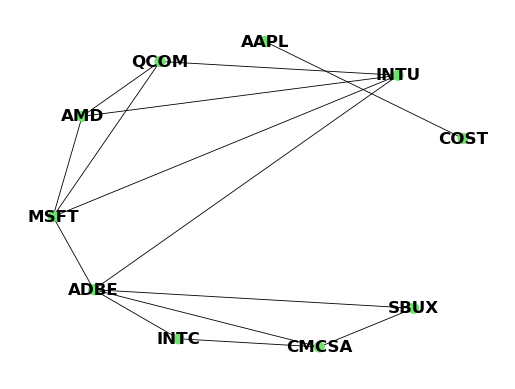

Training Data Shape: torch.Size([408, 11, 20])
Test Data Shape: torch.Size([408, 11, 20])
--- Model Initialization ---
--- Training Begins ---
Day 48 | Epoch 0/40 | Training Loss (MSE): 0.062815
Day 48 | Epoch 5/40 | Training Loss (MSE): 0.008524
Day 48 | Epoch 10/40 | Training Loss (MSE): 0.002543
Day 48 | Epoch 15/40 | Training Loss (MSE): 0.001067
Day 48 | Epoch 20/40 | Training Loss (MSE): 0.000502
Day 48 | Epoch 25/40 | Training Loss (MSE): 0.000384
Day 48 | Epoch 30/40 | Training Loss (MSE): 0.000153
Day 48 | Epoch 35/40 | Training Loss (MSE): 0.000127
Training Completed for Test Day 48 in 5.46 seconds.
Day 48 | Final Test Loss (MSE): 0.000754
MSE for each stock on Test Day 48:
AAPL: 0.000603
MSFT: 0.000168
CMCSA: 0.000543
COST: 0.000004
QCOM: 0.001519
ADBE: 0.000156
SBUX: 0.000644
INTU: 0.003827
AMD: 0.000016
INTC: 0.000057

Real Values in Tabular Form:
Stock  Real Ground Truth (Original)  Real Predicted Values (Original)  Test Day
 AAPL                    142.649994            

c:\ProgramData\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


28
Generated Edge Index for Day 49


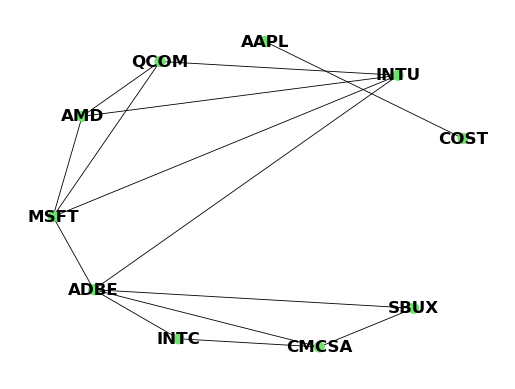

Training Data Shape: torch.Size([408, 11, 20])
Test Data Shape: torch.Size([408, 11, 20])
--- Model Initialization ---
--- Training Begins ---
Day 49 | Epoch 0/40 | Training Loss (MSE): 0.168981
Day 49 | Epoch 5/40 | Training Loss (MSE): 0.046853
Day 49 | Epoch 10/40 | Training Loss (MSE): 0.003359
Day 49 | Epoch 15/40 | Training Loss (MSE): 0.006651
Day 49 | Epoch 20/40 | Training Loss (MSE): 0.002915
Day 49 | Epoch 25/40 | Training Loss (MSE): 0.000406
Day 49 | Epoch 30/40 | Training Loss (MSE): 0.001043
Day 49 | Epoch 35/40 | Training Loss (MSE): 0.000597
Training Completed for Test Day 49 in 6.23 seconds.
Day 49 | Final Test Loss (MSE): 0.000270
MSE for each stock on Test Day 49:
AAPL: 0.000136
MSFT: 0.000263
CMCSA: 0.000218
COST: 0.000041
QCOM: 0.000415
ADBE: 0.000076
SBUX: 0.000931
INTU: 0.000083
AMD: 0.000512
INTC: 0.000022

Real Values in Tabular Form:
Stock  Real Ground Truth (Original)  Real Predicted Values (Original)  Test Day
 AAPL                    142.160004            

c:\ProgramData\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


28
Generated Edge Index for Day 50


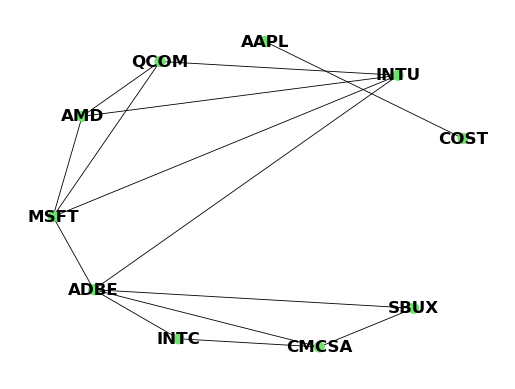

Training Data Shape: torch.Size([408, 11, 20])
Test Data Shape: torch.Size([408, 11, 20])
--- Model Initialization ---
--- Training Begins ---
Day 50 | Epoch 0/40 | Training Loss (MSE): 0.054955
Day 50 | Epoch 5/40 | Training Loss (MSE): 0.010028
Day 50 | Epoch 10/40 | Training Loss (MSE): 0.001939
Day 50 | Epoch 15/40 | Training Loss (MSE): 0.001438
Day 50 | Epoch 20/40 | Training Loss (MSE): 0.001021
Day 50 | Epoch 25/40 | Training Loss (MSE): 0.000365
Day 50 | Epoch 30/40 | Training Loss (MSE): 0.000073
Day 50 | Epoch 35/40 | Training Loss (MSE): 0.000157
Training Completed for Test Day 50 in 5.16 seconds.
Day 50 | Final Test Loss (MSE): 0.000364
MSE for each stock on Test Day 50:
AAPL: 0.000488
MSFT: 0.000528
CMCSA: 0.001192
COST: 0.000102
QCOM: 0.000016
ADBE: 0.000147
SBUX: 0.000241
INTU: 0.000810
AMD: 0.000105
INTC: 0.000007

Real Values in Tabular Form:
Stock  Real Ground Truth (Original)  Real Predicted Values (Original)  Test Day
 AAPL                    142.320007            

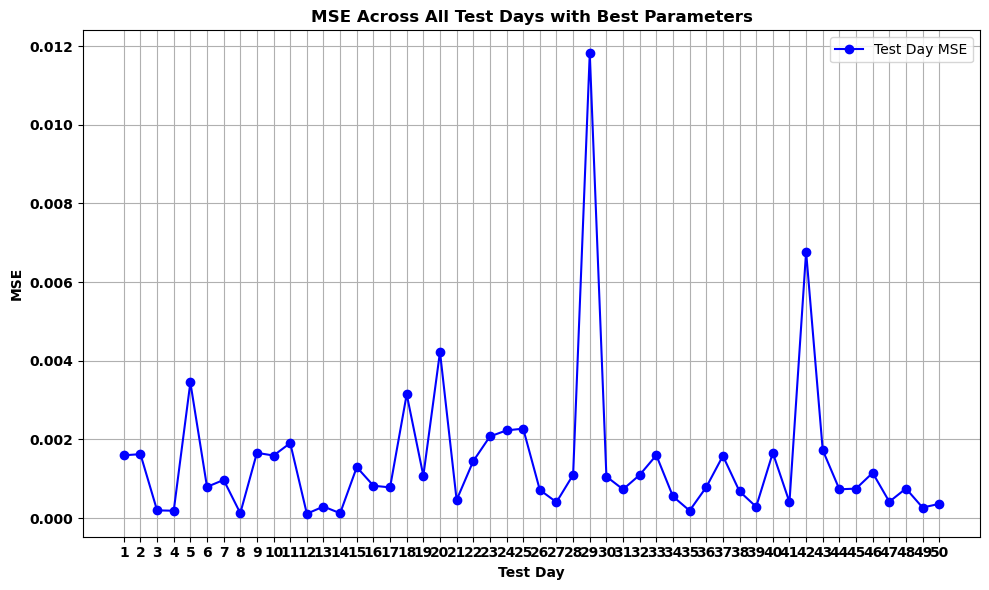

In [11]:
import time
import pandas as pd
import numpy as np
import json
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Load the best parameters from the JSON file
with open('best_params.json', 'r') as file:
    best_params = json.load(file)

best_lr = best_params['Learning Rate']
best_num_epochs = best_params['Epochs']
best_batch_size = best_params['Batch Size']

print(f"\n\n===== Running Model with Best Parameters: Learning Rate = {best_lr}, Epochs = {best_num_epochs}, Batch Size = {best_batch_size} =====\n")

PredictionAlltime = []
GroundTruthAlltime = []
testMse = []
individual_stock_mse = {} 
TestDays = 50

all_predictions_df = pd.DataFrame()

for day in range(TestDays):
    print(f"\n\n===== TEST DAY {day + 1} =====")
    
    # Data Preparation
    print(f"--- Data Preparation ---")
    train_x, train_y, test_x, test_y = Split_Train_Test(AllDataFrame, TestDays, day)

    # Initialize edge index for each test day based on the training data
    edge_index = generateEdge(train_x)
    print(f"Generated Edge Index for Day {day + 1}")
    graphDrawing(edge_index, train_x, stock_files)

    train_x = makeBatch(train_x, best_batch_size)
    train_y = toTensor(outputColumn(train_y))
    test_x = makeBatch(test_x, best_batch_size)
    test_y = toTensor(outputColumn(test_y))
    
    print(f"Training Data Shape: {train_x.shape}")
    print(f"Test Data Shape: {test_x.shape}")

    # Model Initialization
    print(f"--- Model Initialization ---")
    model = Network_RNNplusGNN(
        input_dim=input_dim,
        hidden_dim=hidden_dim, 
        output_dim=output_dim,
        num_layers=num_layers, 
        edge_index=edge_index 
    )

    criterion = torch.nn.MSELoss(reduction='mean')
    optimiser = torch.optim.Adam(model.parameters(), lr=best_lr)

    start_time = time.time()
    print(f"--- Training Begins ---")

    for t in range(best_num_epochs):
        model.train() 
        y_trainPrediction = model(train_x)

        loss = criterion(y_trainPrediction, train_y)
        if t % 5 == 0:
            print(f"Day {day + 1} | Epoch {t}/{best_num_epochs} | Training Loss (MSE): {loss.item():.6f}")

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

    print(f"Training Completed for Test Day {day + 1} in {time.time() - start_time:.2f} seconds.")

    # Testing
    model.eval() 
    with torch.no_grad():
        y_testPrediction = model(test_x)
        test_loss = criterion(y_testPrediction, test_y)

    print(f"Day {day + 1} | Final Test Loss (MSE): {test_loss.item():.6f}")

    testMse.append(test_loss.item())
    real_test_y_all = []
    real_predictions_all = []
    stock_names = []
    
    daily_stock_mse = {}

    test_y_np = test_y.detach().numpy()  
    test_y_np = test_y_np[0]
    y_testPrediction_np = y_testPrediction.detach().numpy() 

    for i, symbol in enumerate(stock_files):
        stock_names.append(symbol)

        real_test_y_scaled = test_y_np[:, i] if test_y_np.ndim == 2 else np.array([test_y_np[i]])
        real_predictions_scaled = y_testPrediction_np[:, i] if y_testPrediction_np.ndim == 2 else np.array([y_testPrediction_np[i]])

        stock_mse = np.mean((real_predictions_scaled - real_test_y_scaled) ** 2)
        daily_stock_mse[symbol] = stock_mse

        real_test_y = ScalerList[i].inverse_transform(real_test_y_scaled.reshape(-1, 1)).flatten()
        real_predictions = ScalerList[i].inverse_transform(real_predictions_scaled.reshape(-1, 1)).flatten()

        real_test_y_all.append(real_test_y)
        real_predictions_all.append(real_predictions)
        
    for stock, mse in daily_stock_mse.items():
        if stock not in individual_stock_mse:
            individual_stock_mse[stock] = []
        individual_stock_mse[stock].append(mse)
    
    print(f"MSE for each stock on Test Day {day + 1}:")
    for stock, mse in daily_stock_mse.items():
        print(f"{stock}: {mse:.6f}")

    result_df = pd.DataFrame({
        'Stock': stock_names,
        'Real Ground Truth (Original)': np.concatenate(real_test_y_all),
        'Real Predicted Values (Original)': np.concatenate(real_predictions_all),
        'Test Day': day + 1  
    })

    all_predictions_df = pd.concat([all_predictions_df, result_df], ignore_index=True)

    print("\nReal Values in Tabular Form:")
    print(result_df.to_string(index=False)) 
    print(f"========================== End of Test Day {day + 1} ==========================\n")

final_mean_mse = np.mean(testMse)
print(f"\nFinal Mean MSE Across All Test Days with Best Parameters: {final_mean_mse:.6f}")

results_df = pd.DataFrame({
    'Day': np.arange(1, TestDays + 1),
    'Test MSE': testMse
})
results_df.to_csv("final_results_best_params.csv", index=False)

all_predictions_df.to_csv("predictions_vs_truth_best_params.csv", index=False)

individual_stock_mse_df = pd.DataFrame(individual_stock_mse)
individual_stock_mse_df.to_csv("individual_stock_mse_best_params.csv", index=False)

plt.figure(figsize=(10, 6))
plt.plot(range(1, TestDays + 1), testMse, marker='o', color='b', linestyle='-', label="Test Day MSE")
plt.title("MSE Across All Test Days with Best Parameters", fontweight='bold')
plt.xlabel("Test Day", fontweight='bold')
plt.ylabel("MSE", fontweight='bold')
plt.xticks(range(1, TestDays + 1), fontweight='bold')
plt.yticks(fontweight='bold')
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.savefig('mse_across_test_days.png', dpi=300, bbox_inches='tight')

plt.show()


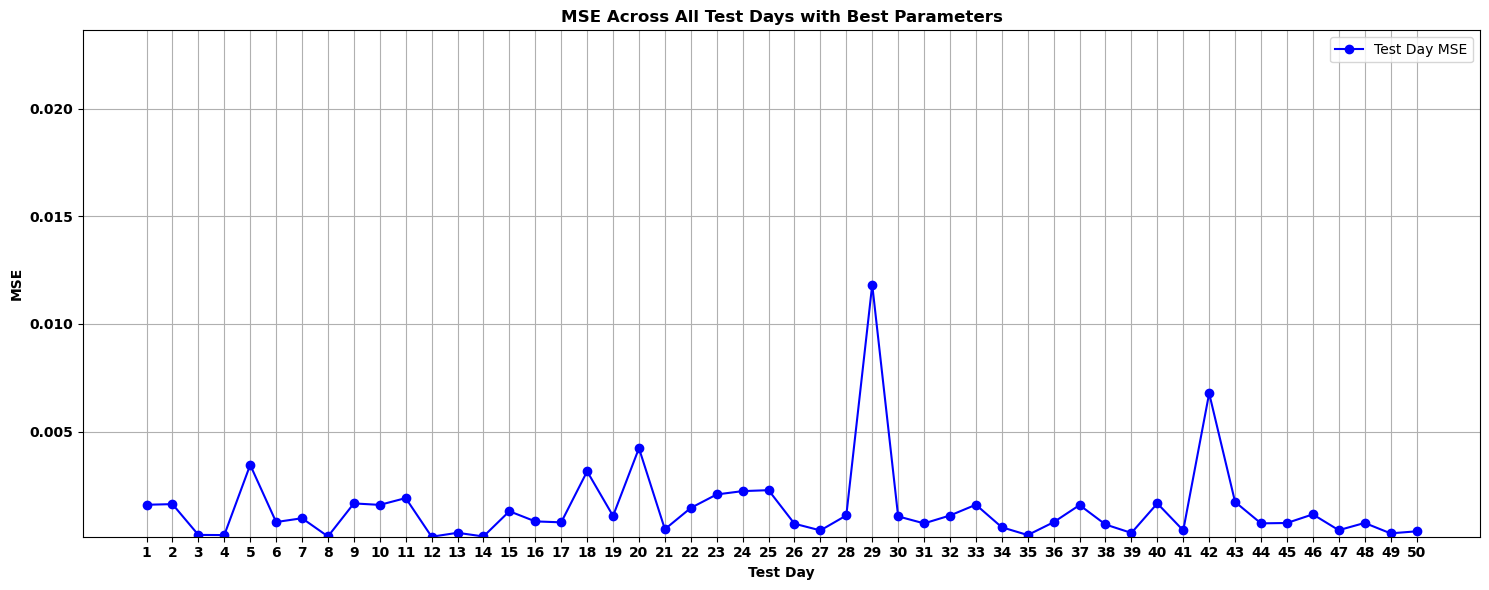

In [12]:
y_min = min(testMse) * 1 
y_max = max(testMse) * 2 

# Plot the MSE for each test day
plt.figure(figsize=(15, 6))
plt.plot(range(1, TestDays + 1), testMse, marker='o', color='b', linestyle='-', label="Test Day MSE")
plt.title("MSE Across All Test Days with Best Parameters", fontweight='bold')
plt.xlabel("Test Day", fontweight='bold')
plt.ylabel("MSE", fontweight='bold')
plt.xticks(range(1, TestDays + 1), fontweight='bold')
plt.yticks(fontweight='bold')
plt.ylim(y_min, y_max)
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.savefig('mse_across_test_days_extended_yaxis.png', dpi=300, bbox_inches='tight')

plt.show()


In [12]:
all_predictions_df

,Stock,Real Ground Truth,Real Predicted Values,Test Day
0,AAPL,142.449982,138.977997,1
1,MSFT,240.740005,230.723923,1
2,CMCSA,30.629999,29.474327,1
3,COST,477.729980,475.783600,1
4,QCOM,117.220001,114.251144,1
...,...,...,...,...
495,ADBE,336.807190,324.741028,50
496,SBUX,102.190010,101.455673,50
497,INTU,406.899994,399.177948,50
498,AMD,69.169998,69.325539,50


In [14]:
results_df

,Day,Test MSE
0,1,0.001505
1,2,0.001840
2,3,0.000155
3,4,0.000215
4,5,0.004143
5,6,0.001048
6,7,0.000568
7,8,0.000152
8,9,0.001660
9,10,0.001680


In [15]:
daily_stock_mse

{'AAPL': 0.15698214,
 'MSFT': 89.48335,
 'CMCSA': 0.89205134,
 'COST': 0.24173811,
 'QCOM': 0.28046218,
 'ADBE': 145.59227,
 'SBUX': 0.5392506,
 'INTU': 59.629993,
 'AMD': 0.024192836,
 'INTC': 0.025677525}